<a href="https://colab.research.google.com/github/Madhuri-V-S/Student-Performance-EDA-Pipeline/blob/main/Student_Performance_EDA_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install all packages
!pip install -q numpy>=1.26.0 pandas>=2.2.0 scikit-learn>=1.4.2 \
    matplotlib>=3.8.0 seaborn>=0.13.0 xgboost>=2.0.3 \
    imbalanced-learn>=0.12.0 shap>=0.45.0 scipy>=1.12.0 \
    statsmodels>=0.14.0 dowhy>=0.12

print("✓ Installation complete! Please RESTART RUNTIME now.")

✓ Installation complete! Please RESTART RUNTIME now.


In [3]:
!pip install dowhy -q

In [4]:
from dowhy import CausalModel
print("✓ DoWhy imported successfully!")

✓ DoWhy imported successfully!


In [5]:
# Run this after restarting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                              roc_auc_score, classification_report, confusion_matrix,
                              roc_curve, auc, precision_recall_curve)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
from statsmodels.stats.contingency_tables import mcnemar

import shap
from dowhy import CausalModel

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ ALL IMPORTS SUCCESSFUL!")

✓ ALL IMPORTS SUCCESSFUL!


In [6]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [7]:
# Load dataset
df = pd.read_csv("data.csv", encoding="latin1")

# Show first rows
df.head()

,"ï»¿Marital status;Application mode;Application order;Course;""Daytime/evening attendance\t"";Previous qualification;Previous qualification (grade);Nacionality;Mother's qualification;Father's qualification;Mother's occupation;Father's occupation;Admission grade;Displaced;Educational special needs;Debtor;Tuition fees up to date;Gender;Scholarship holder;Age at enrollment;International;Curricular units 1st sem (credited);Curricular units 1st sem (enrolled);Curricular units 1st sem (evaluations);Curricular units 1st sem (approved);Curricular units 1st sem (grade);Curricular units 1st sem (without evaluations);Curricular units 2nd sem (credited);Curricular units 2nd sem (enrolled);Curricular units 2nd sem (evaluations);Curricular units 2nd sem (approved);Curricular units 2nd sem (grade);Curricular units 2nd sem (without evaluations);Unemployment rate;Inflation rate;GDP;Target"
0,1;17;5;171;1;1;122.0;1;19;12;5;9;127.3;1;0;0;1...
1,1;15;1;9254;1;1;160.0;1;1;3;3;3;142.5;1;0;0;0;...
2,1;1;5;9070;1;1;122.0;1;37;37;9;9;124.8;1;0;0;0...
3,1;17;2;9773;1;1;122.0;1;38;37;5;3;119.6;1;0;0;...
4,2;39;1;8014;0;1;100.0;1;37;38;9;9;141.5;0;0;0;...


In [8]:
class DataLoader:
    """
    Robust data loading with validation and quality checks

    Features:
    - Automatic format detection (CSV, Excel)
    - Comprehensive quality reporting
    - Missing value analysis
    - Data type detection
    """

    def __init__(self, filepath):
        self.filepath = filepath
        self.df = None
        self.data_quality_report = {}

    def load_data(self):
        """Load data with automatic format detection and proper delimiter handling"""
        try:
            # Try different delimiters for CSV
            if self.filepath.endswith('.csv'):
                # First try semicolon (common in European datasets)
                try:
                    self.df = pd.read_csv(self.filepath, sep=';')
                    if len(self.df.columns) == 1:
                        # If only one column, try comma
                        self.df = pd.read_csv(self.filepath, sep=',')
                except:
                    self.df = pd.read_csv(self.filepath)

            elif self.filepath.endswith(('.xls', '.xlsx')):
                self.df = pd.read_excel(self.filepath)
            else:
                raise ValueError("Unsupported file format. Use CSV or Excel.")

            # Clean column names (remove extra spaces, special characters)
            self.df.columns = self.df.columns.str.strip()

            print(f"✓ Data loaded successfully!")
            print(f"  Shape: {self.df.shape[0]:,} rows × {self.df.shape[1]} columns")
            print(f"  Columns detected: {', '.join(self.df.columns[:5].tolist())}...")
            return self.df

        except Exception as e:
            print(f"✗ Error loading data: {str(e)}")
            return None

    def generate_quality_report(self):
        """Comprehensive data quality assessment"""
        if self.df is None:
            print("✗ No data loaded. Please run load_data() first.")
            return None

        report = {
            'total_rows': len(self.df),
            'total_columns': len(self.df.columns),
            'memory_usage_mb': self.df.memory_usage(deep=True).sum() / 1024**2,
            'duplicates': self.df.duplicated().sum(),
            'missing_values': self.df.isnull().sum().to_dict(),
            'missing_percentage': (self.df.isnull().sum() / len(self.df) * 100).to_dict(),
            'data_types': self.df.dtypes.astype(str).to_dict(),
            'numeric_columns': self.df.select_dtypes(include=[np.number]).columns.tolist(),
            'categorical_columns': self.df.select_dtypes(include=['object', 'category']).columns.tolist()
        }

        self.data_quality_report = report
        return report

    def print_quality_summary(self):
        """Display beautifully formatted quality report"""
        if not self.data_quality_report:
            self.generate_quality_report()

        print("\n" + "="*80)
        print("📊 DATA QUALITY REPORT - STUDENT ACADEMIC PERFORMANCE DATASET")
        print("="*80)

        print(f"\n📦 Dataset Overview:")
        print(f"   Rows: {self.data_quality_report['total_rows']:,}")
        print(f"   Columns: {self.data_quality_report['total_columns']}")
        print(f"   Memory Usage: {self.data_quality_report['memory_usage_mb']:.2f} MB")
        print(f"   Duplicate Rows: {self.data_quality_report['duplicates']:,}")

        print(f"\n🔢 Column Types:")
        print(f"   Numeric Columns: {len(self.data_quality_report['numeric_columns'])}")
        print(f"   Categorical Columns: {len(self.data_quality_report['categorical_columns'])}")

        print(f"\n❓ Missing Values Analysis:")
        missing_cols = {k: v for k, v in self.data_quality_report['missing_percentage'].items() if v > 0}

        if missing_cols:
            print(f"   Total columns with missing values: {len(missing_cols)}")
            print(f"\n   Columns with Missing Data:")
            for col, pct in sorted(missing_cols.items(), key=lambda x: x[1], reverse=True)[:15]:
                count = self.data_quality_report['missing_values'][col]
                bar = '█' * int(pct / 5) + '░' * (20 - int(pct / 5))
                print(f"      • {col[:40]:<40} [{bar}] {count:>5,} ({pct:>5.2f}%)")
        else:
            print("   ✓ No missing values detected!")

        print("\n" + "="*80 + "\n")

    def get_column_info(self):
        """Get detailed information about each column"""
        if self.df is None:
            print("✗ No data loaded.")
            return None

        info_df = pd.DataFrame({
            'Column': self.df.columns,
            'Type': self.df.dtypes.astype(str),
            'Non-Null': len(self.df) - self.df.isnull().sum(),
            'Null': self.df.isnull().sum().values,
            'Null %': (self.df.isnull().sum() / len(self.df) * 100).round(2).values,
            'Unique': [self.df[col].nunique() for col in self.df.columns],
            'Sample Values': [str(self.df[col].dropna().iloc[0])[:30] if len(self.df[col].dropna()) > 0 else 'N/A'
                             for col in self.df.columns]
        })

        return info_df

In [9]:
# ═══════════════════════════════════════════════════════════════════════════════
# EXECUTE SECTION 2A - LOAD AND ANALYZE YOUR DATASET
# ═══════════════════════════════════════════════════════════════════════════════

print("="*80)
print("SECTION 2A: DATA LOADING & QUALITY ASSESSMENT")
print("="*80)

# Step 1: Load the dataset
print("\n📁 STEP 1: Loading Dataset...")
print("-" * 80)

filepath = 'data.csv'  # Your uploaded file
loader = DataLoader(filepath)
df = loader.load_data()

SECTION 2A: DATA LOADING & QUALITY ASSESSMENT

📁 STEP 1: Loading Dataset...
--------------------------------------------------------------------------------
✓ Data loaded successfully!
  Shape: 4,424 rows × 37 columns
  Columns detected: Marital status, Application mode, Application order, Course, Daytime/evening attendance...


In [10]:
if df is not None:
    # Step 2: Generate comprehensive quality report
    print("\n\n📊 STEP 2: Generating Data Quality Report...")
    print("-" * 80)
    loader.generate_quality_report()
    loader.print_quality_summary()

    # Step 3: Detailed column information
    print("\n📋 STEP 3: Detailed Column Information")
    print("-" * 80)
    column_info = loader.get_column_info()
    print(column_info.to_string(index=False))

    # Step 4: Quick statistical overview for numeric columns
    print("\n\n📈 STEP 4: Quick Statistical Summary (Numeric Columns)")
    print("-" * 80)
    if len(loader.data_quality_report['numeric_columns']) > 0:
        print(df[loader.data_quality_report['numeric_columns']].describe().round(2))
    else:
        print("No numeric columns detected.")

    # Step 5: Sample data preview
    print("\n\n👀 STEP 5: Data Preview")
    print("-" * 80)
    print("\n✓ First 3 rows:")
    print(df.head(3))

    print("\n✓ Random 3 rows:")
    print(df.sample(3, random_state=42))

    # Step 6: Identify the target variable
    print("\n\n🎯 STEP 6: Target Variable Detection")
    print("-" * 80)

    # Look for target column
    target_candidates = [col for col in df.columns if 'target' in col.lower()]

    if target_candidates:
        target_col = target_candidates[0]
        print(f"✓ Target variable identified: '{target_col}'")
        print(f"\n  Target Distribution:")
        target_counts = df[target_col].value_counts()
        for val, count in target_counts.items():
            pct = count / len(df) * 100
            print(f"    • {val}: {count:,} samples ({pct:.2f}%)")
    else:
        print("⚠ No 'target' column found. Please specify your target variable.")

    print("\n" + "="*80)
    print("✅ SECTION 2A COMPLETE!")
    print("="*80)
    print("\n💡 Key Insights:")
    print(f"   • Dataset contains {len(df):,} student records")
    print(f"   • {len(loader.data_quality_report['numeric_columns'])} numeric features available")
    print(f"   • {len(loader.data_quality_report['categorical_columns'])} categorical features available")

    if loader.data_quality_report['duplicates'] > 0:
        print(f"   ⚠ Found {loader.data_quality_report['duplicates']} duplicate rows - consider removing")

    missing_cols = {k: v for k, v in loader.data_quality_report['missing_percentage'].items() if v > 0}
    if missing_cols:
        print(f"   ⚠ {len(missing_cols)} columns have missing values - will handle in preprocessing")

    print("\n🚀 Ready for Section 2B: Target Variable Deep Dive & EDA")
    print("="*80)

else:
    print("\n✗ Failed to load data. Please check the file path and format.")



📊 STEP 2: Generating Data Quality Report...
--------------------------------------------------------------------------------

📊 DATA QUALITY REPORT - STUDENT ACADEMIC PERFORMANCE DATASET

📦 Dataset Overview:
   Rows: 4,424
   Columns: 37
   Memory Usage: 1.45 MB
   Duplicate Rows: 0

🔢 Column Types:
   Numeric Columns: 36
   Categorical Columns: 1

❓ Missing Values Analysis:
   ✓ No missing values detected!



📋 STEP 3: Detailed Column Information
--------------------------------------------------------------------------------
                                        Column    Type  Non-Null  Null  Null %  Unique Sample Values
                                Marital status   int64      4424     0     0.0       6             1
                              Application mode   int64      4424     0     0.0      18            17
                             Application order   int64      4424     0     0.0       8             5
                                        Course   int64      4

In [11]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 2B: TARGET VARIABLE ANALYSIS & VISUALIZATION
# Purpose: Deep analysis of the target variable for classification
# ═══════════════════════════════════════════════════════════════════════════════

class TargetAnalyzer:
    """
    Comprehensive target variable analysis for classification problems

    Features:
    - Distribution analysis
    - Class imbalance detection
    - Visual representations
    - Statistical testing
    """

    def __init__(self, df, target_col):
        """
        Initialize the analyzer

        Parameters:
        -----------
        df : pandas.DataFrame
            The dataset
        target_col : str
            Name of the target variable column
        """
        self.df = df.copy()
        self.target_col = target_col
        self.target_values = df[target_col].value_counts()
        self.n_classes = len(self.target_values)

    def analyze_distribution(self):
        """Comprehensive distribution analysis with statistics"""

        print("\n" + "="*80)
        print("🎯 TARGET VARIABLE DISTRIBUTION ANALYSIS")
        print("="*80)

        print(f"\nTarget Variable: '{self.target_col}'")
        print(f"Total Samples: {len(self.df):,}")
        print(f"Number of Classes: {self.n_classes}")

        print(f"\n📊 Class Distribution:")
        print("-" * 80)

        for idx, (class_label, count) in enumerate(self.target_values.items(), 1):
            percentage = (count / len(self.df)) * 100
            bar = '█' * int(percentage / 2) + '░' * (50 - int(percentage / 2))
            print(f"  {idx}. Class '{class_label}':")
            print(f"     Count: {count:,} samples")
            print(f"     Percentage: {percentage:.2f}%")
            print(f"     [{bar}]")
            print()

        # Calculate imbalance ratio
        if self.n_classes == 2:
            majority_count = self.target_values.iloc[0]
            minority_count = self.target_values.iloc[1]
            imbalance_ratio = majority_count / minority_count

            print(f"⚖️  Class Balance Analysis:")
            print(f"   Majority Class: '{self.target_values.index[0]}' ({majority_count:,} samples)")
            print(f"   Minority Class: '{self.target_values.index[1]}' ({minority_count:,} samples)")
            print(f"   Imbalance Ratio: {imbalance_ratio:.2f}:1")

            if imbalance_ratio > 3:
                print(f"   ⚠️  SEVERE IMBALANCE - Resampling strongly recommended!")
            elif imbalance_ratio > 1.5:
                print(f"   ⚠️  MODERATE IMBALANCE - Consider resampling techniques")
            else:
                print(f"   ✓ Relatively balanced dataset")

        elif self.n_classes > 2:
            print(f"⚖️  Multi-Class Balance Analysis:")
            max_count = self.target_values.max()
            min_count = self.target_values.min()
            imbalance_ratio = max_count / min_count
            print(f"   Max Class Size: {max_count:,}")
            print(f"   Min Class Size: {min_count:,}")
            print(f"   Imbalance Ratio: {imbalance_ratio:.2f}:1")

        print("="*80 + "\n")

    def plot_distribution(self, figsize=(16, 6)):
        """Create comprehensive visualizations of target distribution"""

        fig, axes = plt.subplots(1, 3, figsize=figsize)

        # 1. Bar Chart with counts
        ax1 = axes[0]
        colors = plt.cm.Set3(range(self.n_classes))
        bars = ax1.bar(range(self.n_classes), self.target_values.values,
                       color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
        ax1.set_xticks(range(self.n_classes))
        ax1.set_xticklabels(self.target_values.index, fontsize=11, fontweight='bold')
        ax1.set_xlabel('Class Labels', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Frequency (Count)', fontsize=12, fontweight='bold')
        ax1.set_title('Target Variable Distribution\n(Absolute Counts)',
                     fontsize=13, fontweight='bold', pad=15)
        ax1.grid(axis='y', alpha=0.3, linestyle='--')

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

        # 2. Pie Chart with percentages
        ax2 = axes[1]
        wedges, texts, autotexts = ax2.pie(self.target_values.values,
                                           labels=self.target_values.index,
                                           autopct='%1.1f%%',
                                           colors=colors,
                                           explode=[0.05] * self.n_classes,
                                           shadow=True,
                                           startangle=90)

        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(11)

        for text in texts:
            text.set_fontsize(11)
            text.set_fontweight('bold')

        ax2.set_title('Class Proportions\n(Percentage)',
                     fontsize=13, fontweight='bold', pad=15)

        # 3. Horizontal Bar Chart (useful for many classes)
        ax3 = axes[2]
        y_pos = np.arange(self.n_classes)
        percentages = (self.target_values.values / len(self.df)) * 100

        bars = ax3.barh(y_pos, percentages, color=colors,
                       edgecolor='black', linewidth=1.5, alpha=0.8)
        ax3.set_yticks(y_pos)
        ax3.set_yticklabels(self.target_values.index, fontsize=11, fontweight='bold')
        ax3.set_xlabel('Percentage (%)', fontsize=12, fontweight='bold')
        ax3.set_title('Class Distribution\n(Percentage View)',
                     fontsize=13, fontweight='bold', pad=15)
        ax3.grid(axis='x', alpha=0.3, linestyle='--')

        # Add percentage labels
        for i, (bar, pct) in enumerate(zip(bars, percentages)):
            width = bar.get_width()
            ax3.text(width + 1, bar.get_y() + bar.get_height()/2.,
                    f'{pct:.1f}%',
                    ha='left', va='center', fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.show()

    def target_summary_table(self):
        """Create a publication-ready summary table"""

        summary_data = []
        for class_label, count in self.target_values.items():
            percentage = (count / len(self.df)) * 100
            summary_data.append({
                'Class': class_label,
                'Count': count,
                'Percentage (%)': round(percentage, 2),
                'Cumulative %': round(sum(self.target_values.iloc[:list(self.target_values.index).index(class_label)+1]) / len(self.df) * 100, 2)
            })

        summary_df = pd.DataFrame(summary_data)

        print("\n" + "="*80)
        print("📋 TARGET VARIABLE SUMMARY TABLE")
        print("="*80)
        print(summary_df.to_string(index=False))
        print("="*80 + "\n")

        return summary_df

    def recommend_strategy(self):
        """Provide recommendations based on class distribution"""

        print("\n" + "="*80)
        print("💡 RECOMMENDATIONS FOR MODELING")
        print("="*80)

        if self.n_classes == 2:
            majority_count = self.target_values.iloc[0]
            minority_count = self.target_values.iloc[1]
            imbalance_ratio = majority_count / minority_count

            print("\n🎯 Classification Type: BINARY CLASSIFICATION")
            print(f"   Imbalance Ratio: {imbalance_ratio:.2f}:1")

            print("\n📊 Recommended Evaluation Metrics:")
            if imbalance_ratio > 1.5:
                print("   ✓ F1-Score (weighted)")
                print("   ✓ Precision and Recall")
                print("   ✓ AUC-ROC")
                print("   ✓ AUC-PR (Precision-Recall)")
                print("   ✗ Accuracy (misleading for imbalanced data)")
            else:
                print("   ✓ Accuracy")
                print("   ✓ F1-Score")
                print("   ✓ AUC-ROC")

            print("\n⚙️  Recommended Techniques:")
            if imbalance_ratio > 3:
                print("   1. SMOTE (Synthetic Minority Over-sampling)")
                print("   2. Class weights in model (class_weight='balanced')")
                print("   3. Ensemble methods (Random Forest, XGBoost)")
                print("   4. Consider stratified cross-validation")
            elif imbalance_ratio > 1.5:
                print("   1. Class weights in model")
                print("   2. Stratified sampling in train-test split")
                print("   3. Consider SMOTE if performance is poor")
            else:
                print("   1. Standard train-test split")
                print("   2. Cross-validation")
                print("   3. No special imbalance handling needed")

        else:
            print("\n🎯 Classification Type: MULTI-CLASS CLASSIFICATION")
            print(f"   Number of Classes: {self.n_classes}")

            print("\n📊 Recommended Evaluation Metrics:")
            print("   ✓ Macro-averaged F1-Score")
            print("   ✓ Weighted F1-Score")
            print("   ✓ Confusion Matrix")
            print("   ✓ Per-class Precision/Recall")

            print("\n⚙️  Recommended Techniques:")
            print("   1. Stratified cross-validation")
            print("   2. One-vs-Rest or One-vs-One strategies")
            print("   3. Class weights if imbalanced")

        print("="*80 + "\n")


SECTION 2B: TARGET VARIABLE ANALYSIS

✓ Target column 'Target' found!

📊 STEP 1: Distribution Analysis
--------------------------------------------------------------------------------

🎯 TARGET VARIABLE DISTRIBUTION ANALYSIS

Target Variable: 'Target'
Total Samples: 4,424
Number of Classes: 3

📊 Class Distribution:
--------------------------------------------------------------------------------
  1. Class 'Graduate':
     Count: 2,209 samples
     Percentage: 49.93%
     [████████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░]

  2. Class 'Dropout':
     Count: 1,421 samples
     Percentage: 32.12%
     [████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]

  3. Class 'Enrolled':
     Count: 794 samples
     Percentage: 17.95%
     [████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]

⚖️  Multi-Class Balance Analysis:
   Max Class Size: 2,209
   Min Class Size: 794
   Imbalance Ratio: 2.78:1


📈 STEP 2: Creating Visualizations...
------------------------------------------------------------

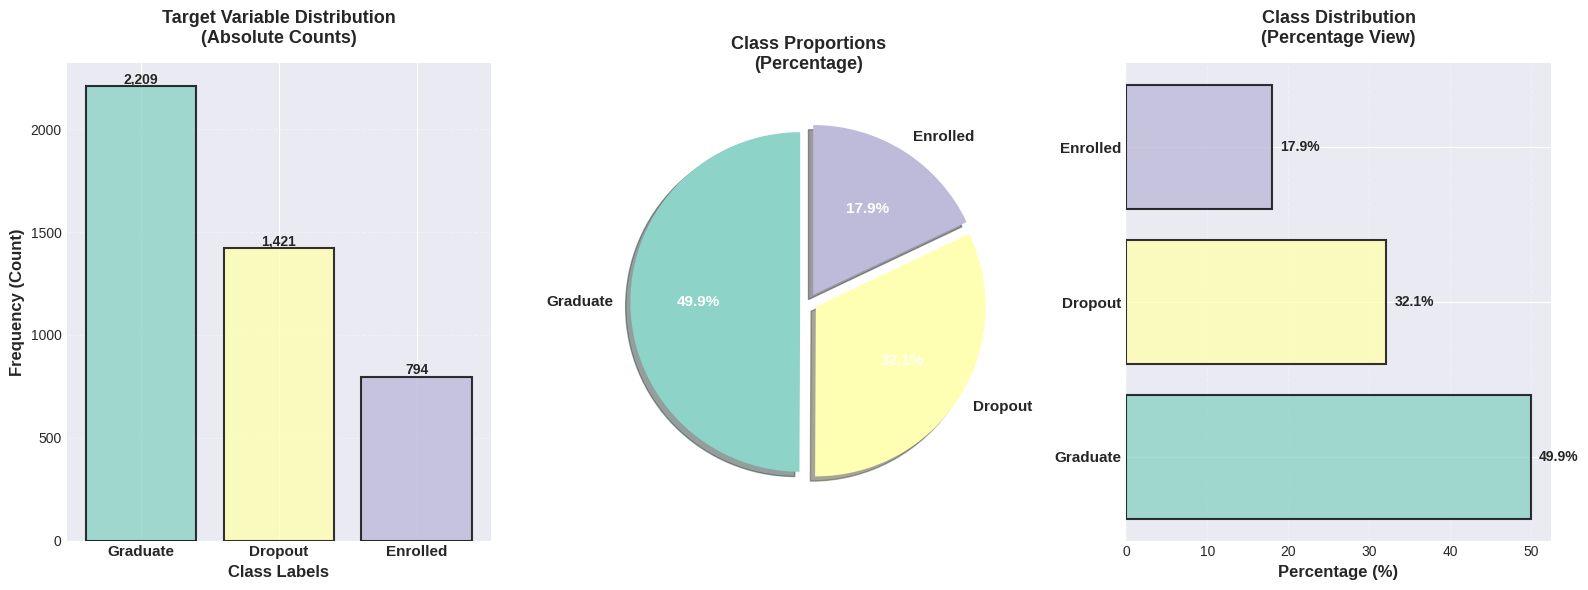


📋 STEP 3: Summary Table
--------------------------------------------------------------------------------

📋 TARGET VARIABLE SUMMARY TABLE
   Class  Count  Percentage (%)  Cumulative %
Graduate   2209           49.93         49.93
 Dropout   1421           32.12         82.05
Enrolled    794           17.95        100.00


💡 STEP 4: Modeling Recommendations
--------------------------------------------------------------------------------

💡 RECOMMENDATIONS FOR MODELING

🎯 Classification Type: MULTI-CLASS CLASSIFICATION
   Number of Classes: 3

📊 Recommended Evaluation Metrics:
   ✓ Macro-averaged F1-Score
   ✓ Weighted F1-Score
   ✓ Confusion Matrix
   ✓ Per-class Precision/Recall

⚙️  Recommended Techniques:
   1. Stratified cross-validation
   2. One-vs-Rest or One-vs-One strategies
   3. Class weights if imbalanced


✅ SECTION 2B COMPLETE!

🚀 Ready for Section 2C: Numeric Features Analysis


In [12]:
# ═══════════════════════════════════════════════════════════════════════════════
# EXECUTE SECTION 2B - ANALYZE YOUR TARGET VARIABLE
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SECTION 2B: TARGET VARIABLE ANALYSIS")
print("="*80)

# YOU NEED TO SPECIFY YOUR TARGET COLUMN NAME HERE
# Look at the output from Section 2A to find the exact target column name
target_column = 'Target'  # REPLACE with your actual target column name

# Check if target column exists
if target_column in df.columns:
    print(f"\n✓ Target column '{target_column}' found!")

    # Initialize analyzer
    analyzer = TargetAnalyzer(df, target_column)

    # Step 1: Analyze distribution
    print("\n📊 STEP 1: Distribution Analysis")
    print("-" * 80)
    analyzer.analyze_distribution()

    # Step 2: Create visualizations
    print("\n📈 STEP 2: Creating Visualizations...")
    print("-" * 80)
    analyzer.plot_distribution()

    # Step 3: Generate summary table
    print("\n📋 STEP 3: Summary Table")
    print("-" * 80)
    summary_table = analyzer.target_summary_table()

    # Step 4: Get recommendations
    print("\n💡 STEP 4: Modeling Recommendations")
    print("-" * 80)
    analyzer.recommend_strategy()

    print("\n" + "="*80)
    print("✅ SECTION 2B COMPLETE!")
    print("="*80)
    print("\n🚀 Ready for Section 2C: Numeric Features Analysis")
    print("="*80)

else:
    print(f"\n✗ Error: Column '{target_column}' not found in dataset!")
    print(f"\nAvailable columns:")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i}. {col}")
    print("\n⚠️  Please update the 'target_column' variable with the correct column name.")

In [13]:
class NumericFeatureAnalyzer:
    """
    Publication-grade numeric feature analysis

    Features:
    - Univariate analysis
    - Distribution analysis by target class
    - Statistical significance testing
    - Outlier detection and visualization
    - Correlation analysis
    """

    def __init__(self, df, target_col):
        """
        Initialize analyzer

        Parameters:
        -----------
        df : pandas.DataFrame
            The dataset
        target_col : str
            Name of the target variable
        """
        self.df = df.copy()
        self.target_col = target_col
        self.numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

        # Remove target if it's numeric
        if target_col in self.numeric_cols:
            self.numeric_cols.remove(target_col)

        self.n_features = len(self.numeric_cols)
        print(f"✓ Initialized with {self.n_features} numeric features")

    def descriptive_statistics(self):
        """Generate comprehensive descriptive statistics table"""

        print("\n" + "="*80)
        print("📊 DESCRIPTIVE STATISTICS - NUMERIC FEATURES")
        print("="*80)

        if self.n_features == 0:
            print("No numeric features found.")
            return None

        # Basic statistics
        stats_df = self.df[self.numeric_cols].describe().T

        # Add additional statistics
        stats_df['variance'] = self.df[self.numeric_cols].var()
        stats_df['skewness'] = self.df[self.numeric_cols].skew()
        stats_df['kurtosis'] = self.df[self.numeric_cols].kurtosis()
        stats_df['missing'] = self.df[self.numeric_cols].isnull().sum()
        stats_df['missing_pct'] = (self.df[self.numeric_cols].isnull().sum() / len(self.df) * 100).round(2)

        # Reorder columns for better readability
        cols_order = ['count', 'missing', 'missing_pct', 'mean', 'std', 'min', '25%', '50%', '75%', 'max',
                     'variance', 'skewness', 'kurtosis']
        stats_df = stats_df[cols_order]

        print("\n" + stats_df.to_string())
        print("\n" + "="*80)

        # Interpretation guide
        print("\n💡 INTERPRETATION GUIDE:")
        print("-" * 80)
        print("  • Skewness > |1|: Highly skewed (may need transformation)")
        print("  • Skewness 0.5-1: Moderately skewed")
        print("  • Skewness < 0.5: Approximately symmetric")
        print("  • Kurtosis > 3: Heavy-tailed (more outliers than normal)")
        print("  • Kurtosis < 3: Light-tailed (fewer outliers)")
        print("="*80 + "\n")

        return stats_df

    def distribution_by_target(self, n_cols=4, figsize=(20, 5)):
        """
        Analyze feature distributions split by target class
        Publication-quality visualizations
        """

        print("\n" + "="*80)
        print("📈 FEATURE DISTRIBUTIONS BY TARGET CLASS")
        print("="*80)

        if self.n_features == 0:
            print("No numeric features to analyze.")
            return

        # Get target classes
        target_classes = sorted(self.df[self.target_col].unique())
        n_classes = len(target_classes)

        # Create plots in batches
        n_plots_per_fig = n_cols
        n_figures = int(np.ceil(self.n_features / n_plots_per_fig))

        for fig_idx in range(n_figures):
            start_idx = fig_idx * n_plots_per_fig
            end_idx = min(start_idx + n_plots_per_fig, self.n_features)
            current_features = self.numeric_cols[start_idx:end_idx]

            n_current = len(current_features)
            fig, axes = plt.subplots(1, n_current, figsize=(figsize[0], figsize[1]))

            if n_current == 1:
                axes = [axes]

            for idx, feature in enumerate(current_features):
                ax = axes[idx]

                # Plot distributions for each class
                for class_val in target_classes:
                    data = self.df[self.df[self.target_col] == class_val][feature].dropna()

                    ax.hist(data, alpha=0.6, bins=30, label=f'Class {class_val}',
                           edgecolor='black', linewidth=0.5)

                ax.set_xlabel(feature, fontsize=10, fontweight='bold')
                ax.set_ylabel('Frequency', fontsize=10, fontweight='bold')
                ax.set_title(f'{feature}\nDistribution by Target', fontsize=11, fontweight='bold')
                ax.legend(loc='best', fontsize=9)
                ax.grid(alpha=0.3, linestyle='--')

            plt.suptitle(f'Feature Distributions - Batch {fig_idx + 1}/{n_figures}',
                        fontsize=14, fontweight='bold', y=1.02)
            plt.tight_layout()
            plt.show()

        print(f"\n✓ Generated {n_figures} figure(s) with distribution plots")
        print("="*80 + "\n")

    def statistical_significance_tests(self):
        """
        Perform statistical tests to identify features with significant differences across classes
        Essential for publication-grade analysis
        """

        print("\n" + "="*80)
        print("📊 STATISTICAL SIGNIFICANCE TESTING")
        print("="*80)

        if self.n_features == 0:
            print("No numeric features to test.")
            return None

        target_classes = sorted(self.df[self.target_col].unique())
        n_classes = len(target_classes)

        results = []

        print(f"\nTesting {self.n_features} features across {n_classes} classes...")
        print("-" * 80)

        for feature in self.numeric_cols:
            # Remove missing values
            valid_data = self.df[[feature, self.target_col]].dropna()

            if n_classes == 2:
                # Two-sample t-test for binary classification
                class_0_data = valid_data[valid_data[self.target_col] == target_classes[0]][feature]
                class_1_data = valid_data[valid_data[self.target_col] == target_classes[1]][feature]

                # Perform t-test
                t_stat, p_value = ttest_ind(class_0_data, class_1_data, equal_var=False)

                # Effect size (Cohen's d)
                mean_diff = class_0_data.mean() - class_1_data.mean()
                pooled_std = np.sqrt((class_0_data.std()**2 + class_1_data.std()**2) / 2)
                cohens_d = mean_diff / pooled_std if pooled_std != 0 else 0

                results.append({
                    'Feature': feature,
                    'Test': 't-test',
                    't-statistic': round(t_stat, 4),
                    'p-value': round(p_value, 6),
                    'Cohens_d': round(abs(cohens_d), 4),
                    'Significant': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
                })

            else:
                # ANOVA for multi-class classification
                groups = [valid_data[valid_data[self.target_col] == cls][feature].values
                         for cls in target_classes]

                f_stat, p_value = stats.f_oneway(*groups)

                results.append({
                    'Feature': feature,
                    'Test': 'ANOVA',
                    'F-statistic': round(f_stat, 4),
                    'p-value': round(p_value, 6),
                    'Significant': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
                })

        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('p-value')

        print("\n" + results_df.to_string(index=False))

        print("\n" + "-"*80)
        print("SIGNIFICANCE LEVELS:")
        print("  *** p < 0.001 (Highly significant)")
        print("  **  p < 0.01  (Very significant)")
        print("  *   p < 0.05  (Significant)")
        print("  ns  p ≥ 0.05  (Not significant)")

        if n_classes == 2:
            print("\nEFFECT SIZE (Cohen's d):")
            print("  |d| < 0.2: Small effect")
            print("  0.2 ≤ |d| < 0.5: Medium effect")
            print("  |d| ≥ 0.5: Large effect")

        # Count significant features
        n_significant = len(results_df[results_df['Significant'] != 'ns'])
        print(f"\n✓ {n_significant}/{self.n_features} features show significant differences (p < 0.05)")
        print("="*80 + "\n")

        return results_df

    def outlier_analysis(self, figsize=(20, 5)):
        """
        Comprehensive outlier detection using IQR method
        Box plots by target class
        """

        print("\n" + "="*80)
        print("📦 OUTLIER DETECTION ANALYSIS")
        print("="*80)

        if self.n_features == 0:
            print("No numeric features to analyze.")
            return None

        target_classes = sorted(self.df[self.target_col].unique())
        outlier_summary = []

        # Create box plots in batches
        n_plots_per_fig = 5
        n_figures = int(np.ceil(self.n_features / n_plots_per_fig))

        for fig_idx in range(n_figures):
            start_idx = fig_idx * n_plots_per_fig
            end_idx = min(start_idx + n_plots_per_fig, self.n_features)
            current_features = self.numeric_cols[start_idx:end_idx]

            n_current = len(current_features)
            fig, axes = plt.subplots(1, n_current, figsize=(figsize[0], figsize[1]))

            if n_current == 1:
                axes = [axes]

            for idx, feature in enumerate(current_features):
                ax = axes[idx]

                # Prepare data for box plot
                data_by_class = [self.df[self.df[self.target_col] == cls][feature].dropna()
                                for cls in target_classes]

                # Create box plot
                bp = ax.boxplot(data_by_class, labels=target_classes, patch_artist=True,
                               showmeans=True, meanline=True)

                # Color the boxes
                colors = plt.cm.Set3(range(len(target_classes)))
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)

                ax.set_xlabel('Target Class', fontsize=10, fontweight='bold')
                ax.set_ylabel(feature, fontsize=10, fontweight='bold')
                ax.set_title(f'{feature}\nOutlier Detection', fontsize=11, fontweight='bold')
                ax.grid(alpha=0.3, axis='y', linestyle='--')

                # Calculate outliers using IQR method
                for cls in target_classes:
                    class_data = self.df[self.df[self.target_col] == cls][feature].dropna()
                    Q1 = class_data.quantile(0.25)
                    Q3 = class_data.quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - 1.5 * IQR
                    upper_bound = Q3 + 1.5 * IQR

                    outliers = class_data[(class_data < lower_bound) | (class_data > upper_bound)]
                    n_outliers = len(outliers)
                    outlier_pct = (n_outliers / len(class_data) * 100) if len(class_data) > 0 else 0

                    outlier_summary.append({
                        'Feature': feature,
                        'Class': cls,
                        'N_Outliers': n_outliers,
                        'Outlier_Pct': round(outlier_pct, 2),
                        'Lower_Bound': round(lower_bound, 2),
                        'Upper_Bound': round(upper_bound, 2)
                    })

            plt.suptitle(f'Outlier Detection - Batch {fig_idx + 1}/{n_figures}',
                        fontsize=14, fontweight='bold', y=1.02)
            plt.tight_layout()
            plt.show()

        # Summary table
        outlier_df = pd.DataFrame(outlier_summary)

        print("\n📋 OUTLIER SUMMARY TABLE:")
        print("-" * 80)
        print(outlier_df.to_string(index=False))

        # Overall summary
        total_outliers = outlier_df['N_Outliers'].sum()
        features_with_outliers = outlier_df[outlier_df['N_Outliers'] > 0]['Feature'].nunique()

        print("\n" + "-"*80)
        print(f"✓ Total outliers detected: {total_outliers:,}")
        print(f"✓ Features with outliers: {features_with_outliers}/{self.n_features}")
        print("\n💡 Outliers identified using IQR method (Q1 - 1.5×IQR, Q3 + 1.5×IQR)")
        print("="*80 + "\n")

        return outlier_df


SECTION 2C: NUMERIC FEATURES DEEP ANALYSIS
✓ Initialized with 36 numeric features

📊 STEP 1: Comprehensive Descriptive Statistics
--------------------------------------------------------------------------------

📊 DESCRIPTIVE STATISTICS - NUMERIC FEATURES

                                                 count  missing  missing_pct         mean          std    min      25%          50%          75%          max      variance   skewness    kurtosis
Marital status                                  4424.0        0          0.0     1.178571     0.605747   1.00     1.00     1.000000     1.000000     6.000000  3.669294e-01   4.399764   21.482639
Application mode                                4424.0        0          0.0    18.669078    17.484682   1.00     1.00    17.000000    39.000000    57.000000  3.057141e+02   0.393036   -1.453806
Application order                               4424.0        0          0.0     1.727848     1.313793   0.00     1.00     1.000000     2.000000     9.000000

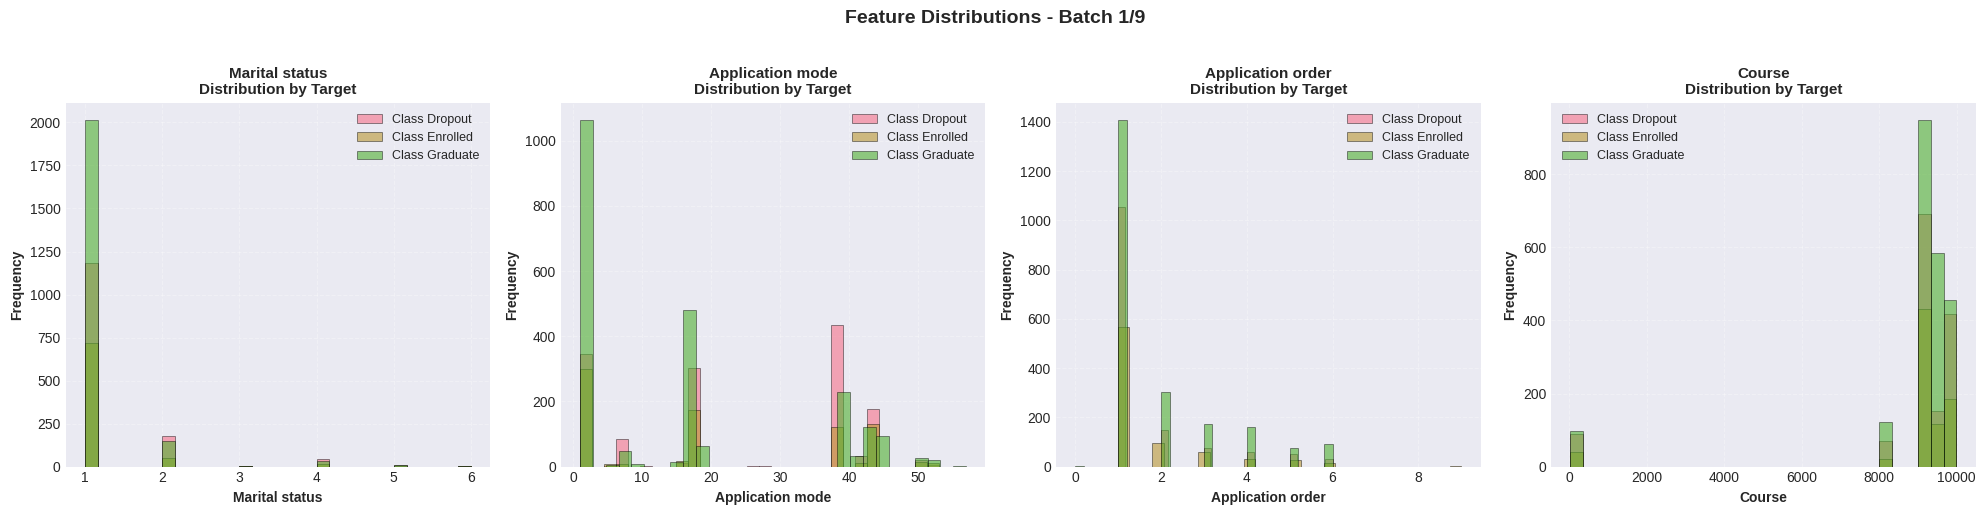

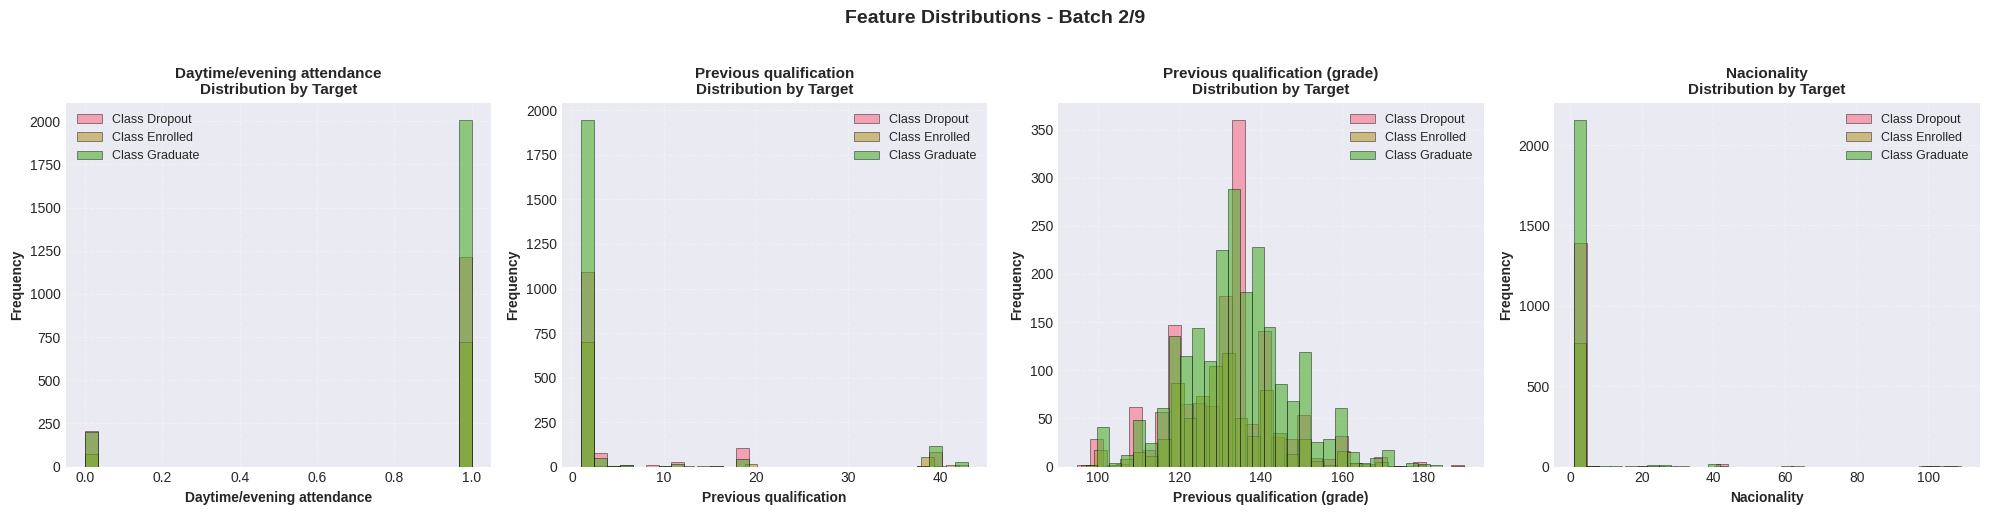

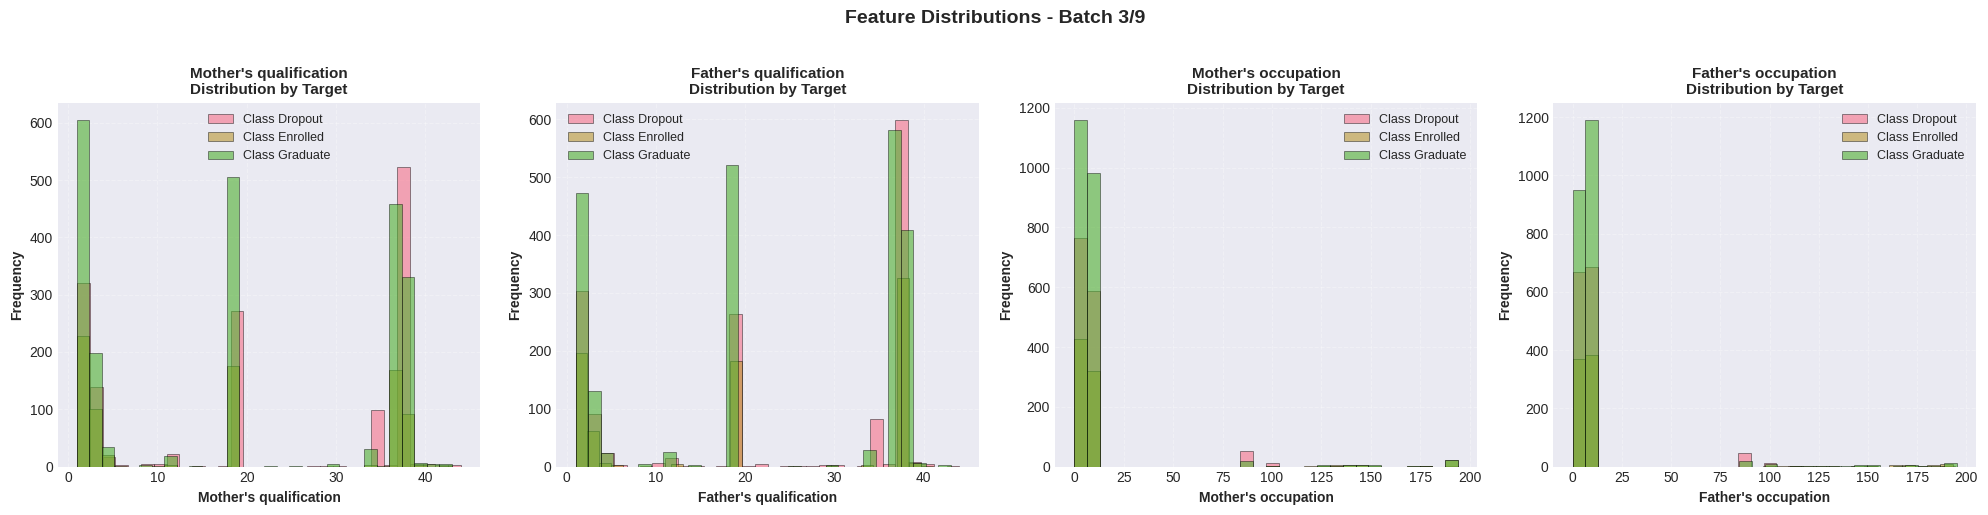

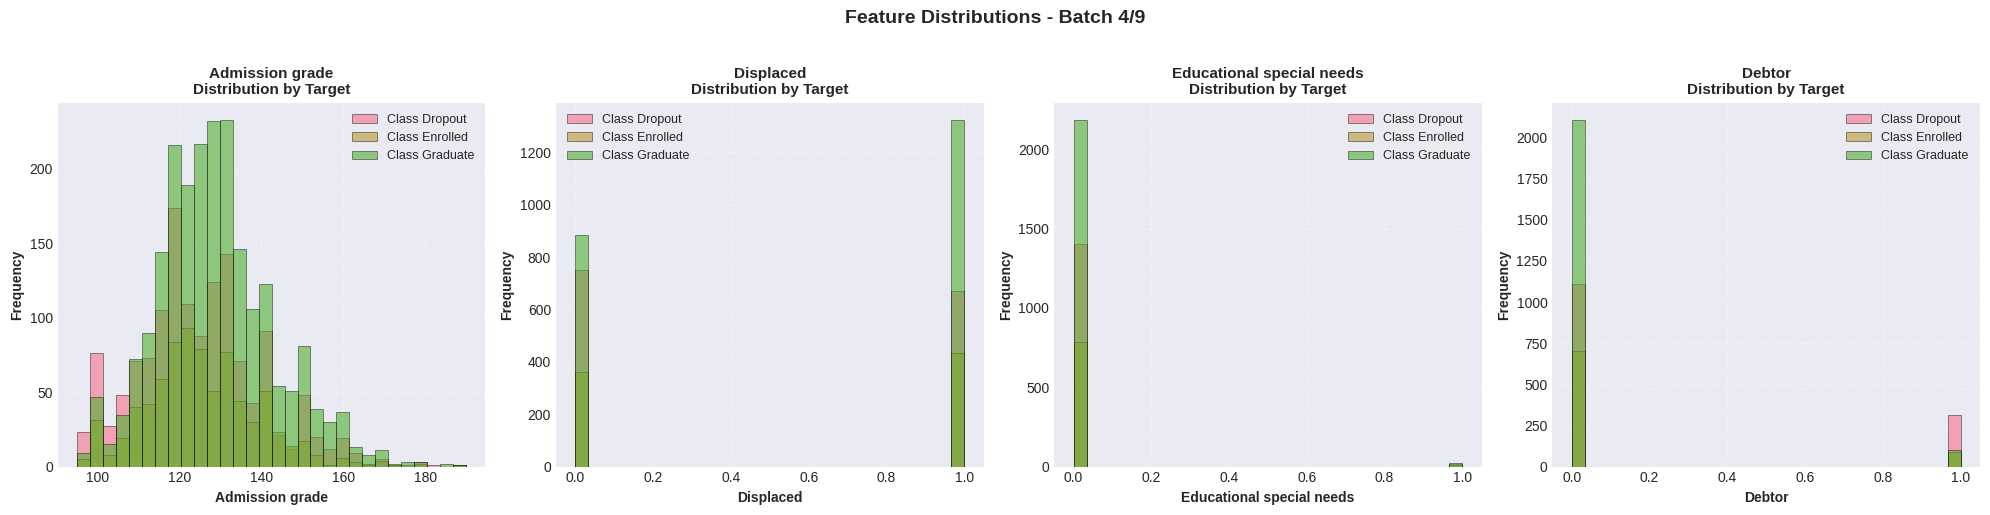

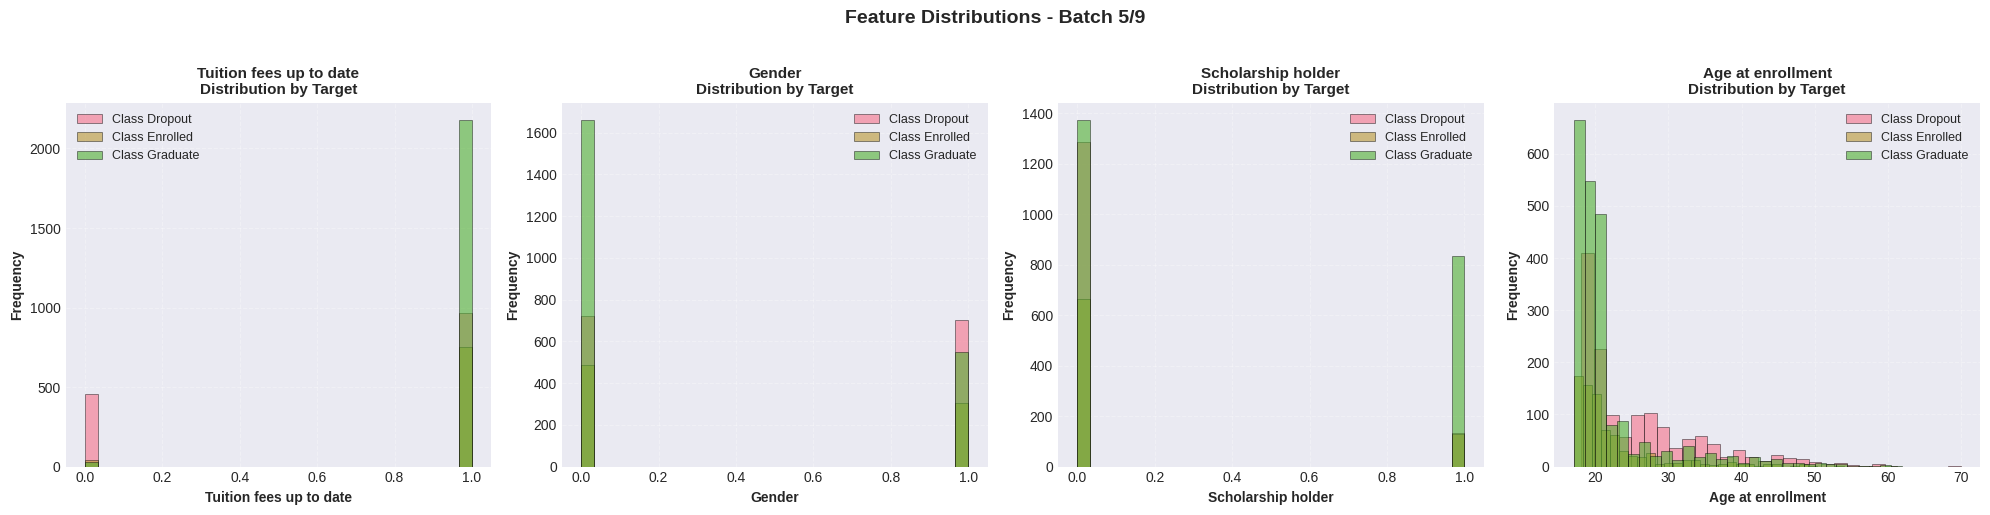

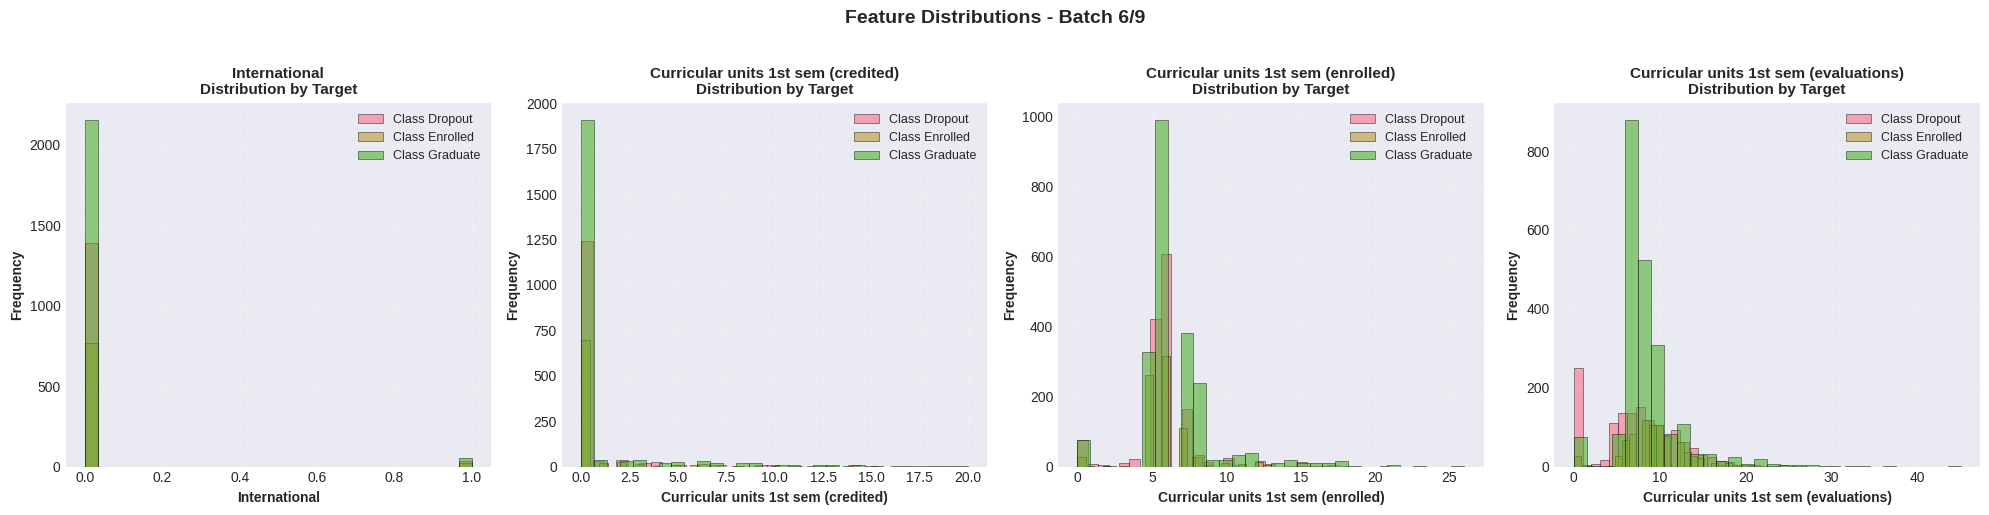

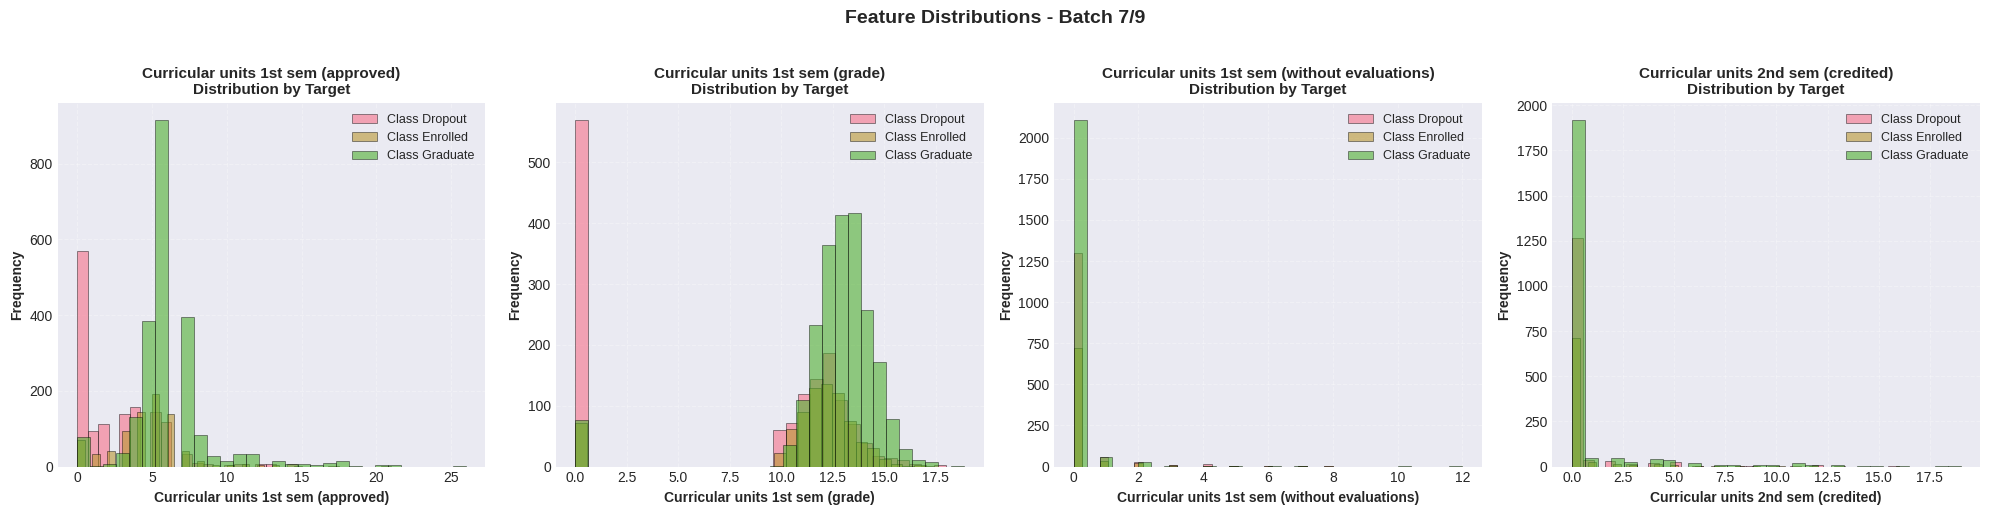

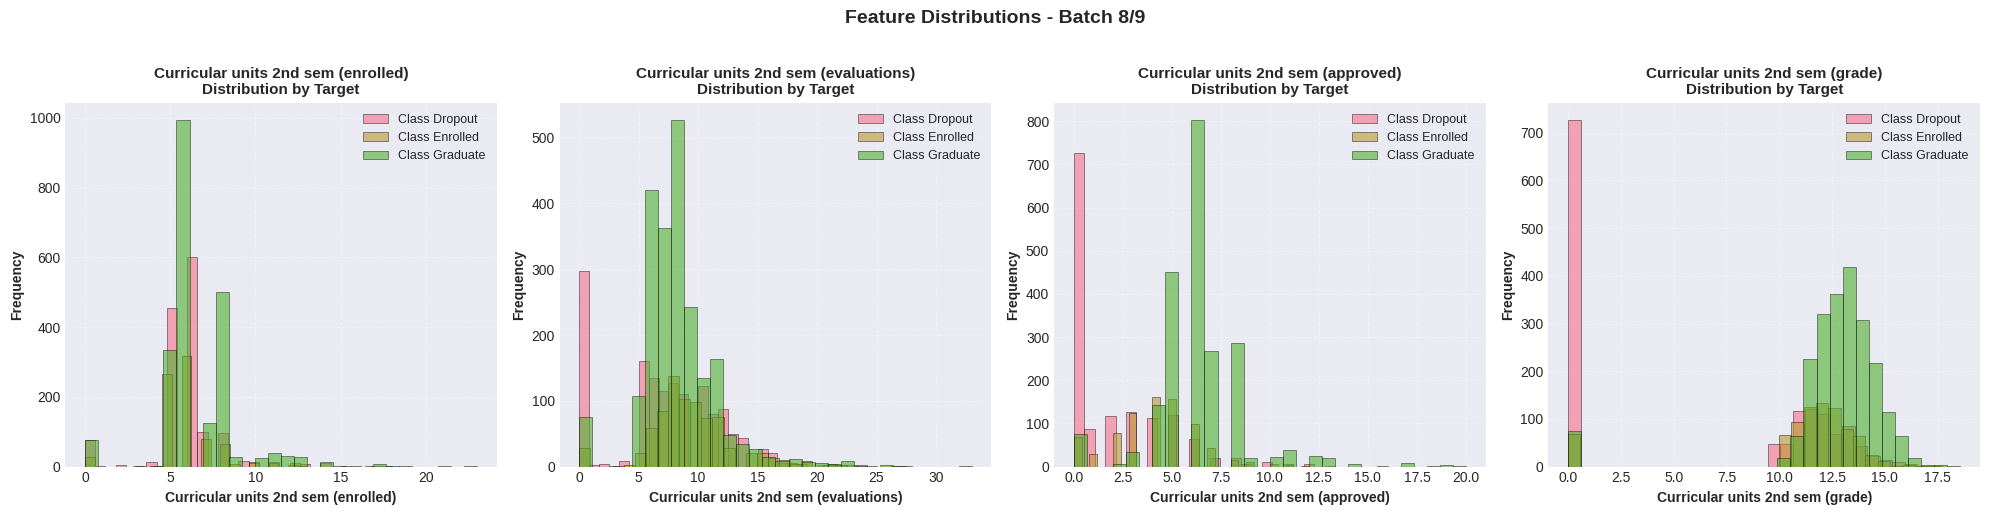

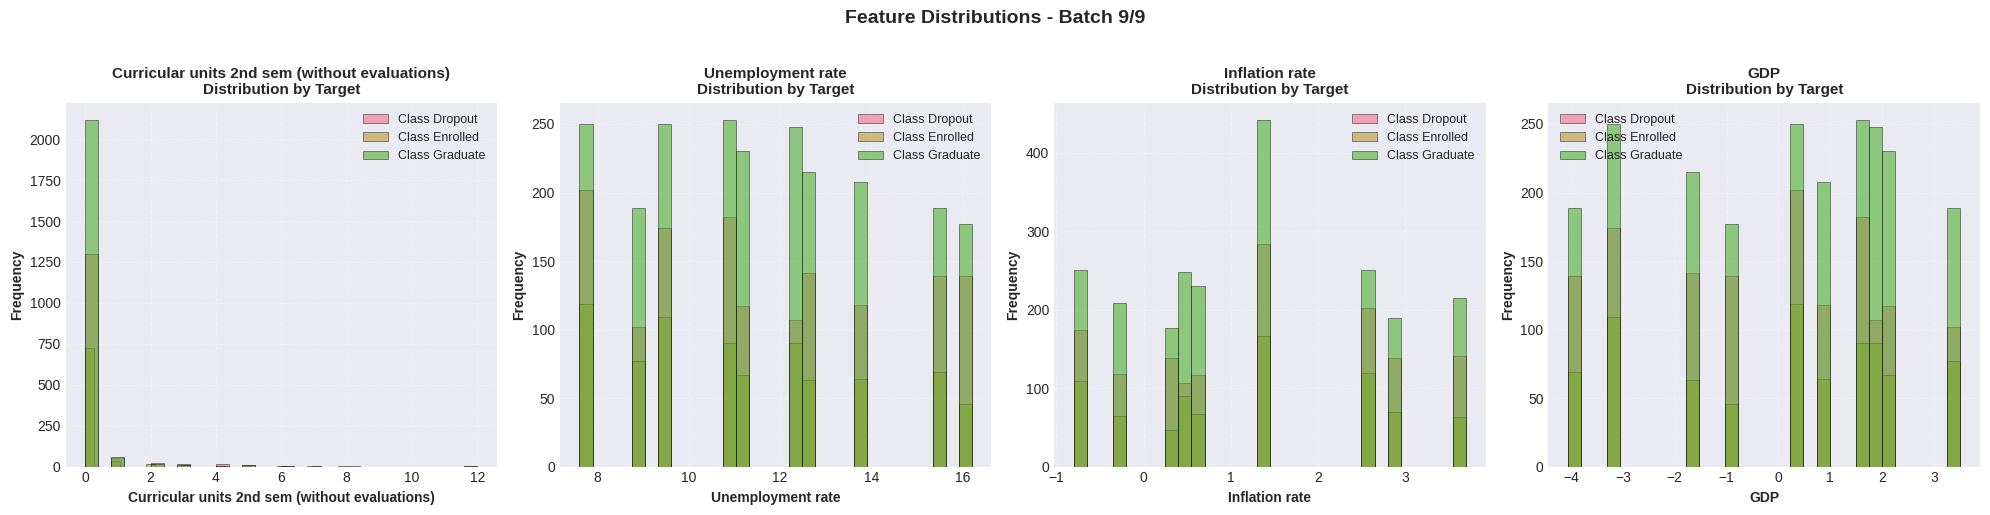


✓ Generated 9 figure(s) with distribution plots


📊 STEP 3: Statistical Significance Testing
--------------------------------------------------------------------------------

📊 STATISTICAL SIGNIFICANCE TESTING

Testing 36 features across 3 classes...
--------------------------------------------------------------------------------

                                       Feature  Test  F-statistic  p-value Significant
                                Marital status ANOVA      19.8323 0.000000         ***
                              Application mode ANOVA     114.5350 0.000000         ***
                             Application order ANOVA      19.7272 0.000000         ***
                Previous qualification (grade) ANOVA      27.7286 0.000000         ***
                                        Debtor ANOVA     137.6475 0.000000         ***
                               Admission grade ANOVA      35.6486 0.000000         ***
                                     Displaced ANOVA     

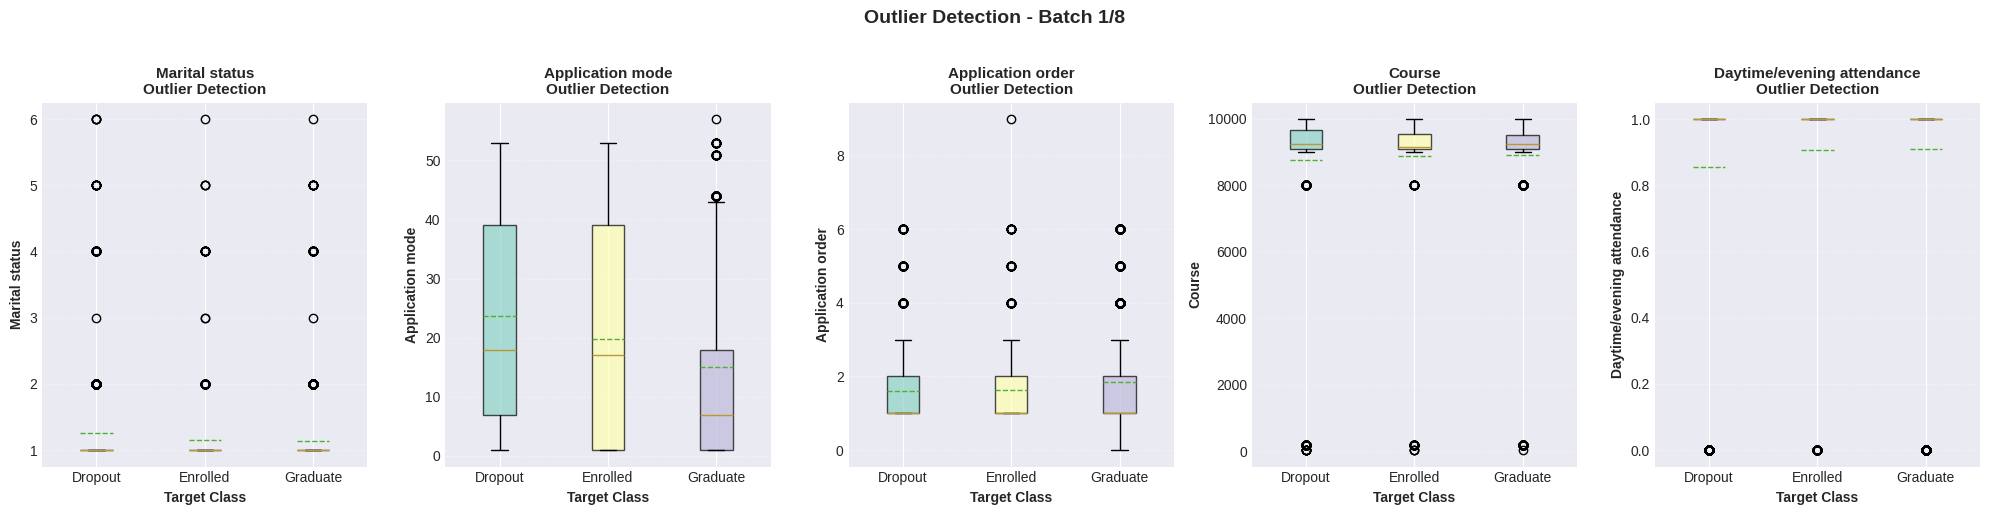

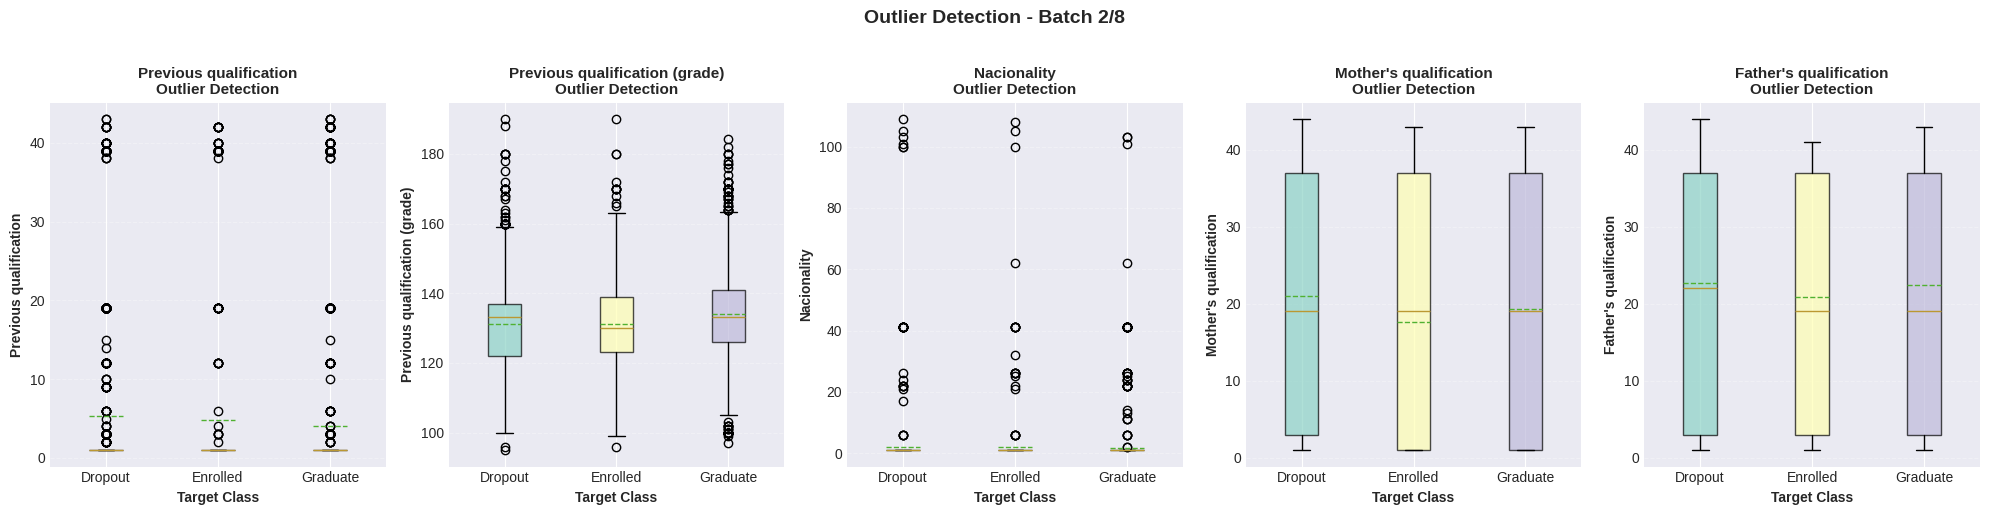

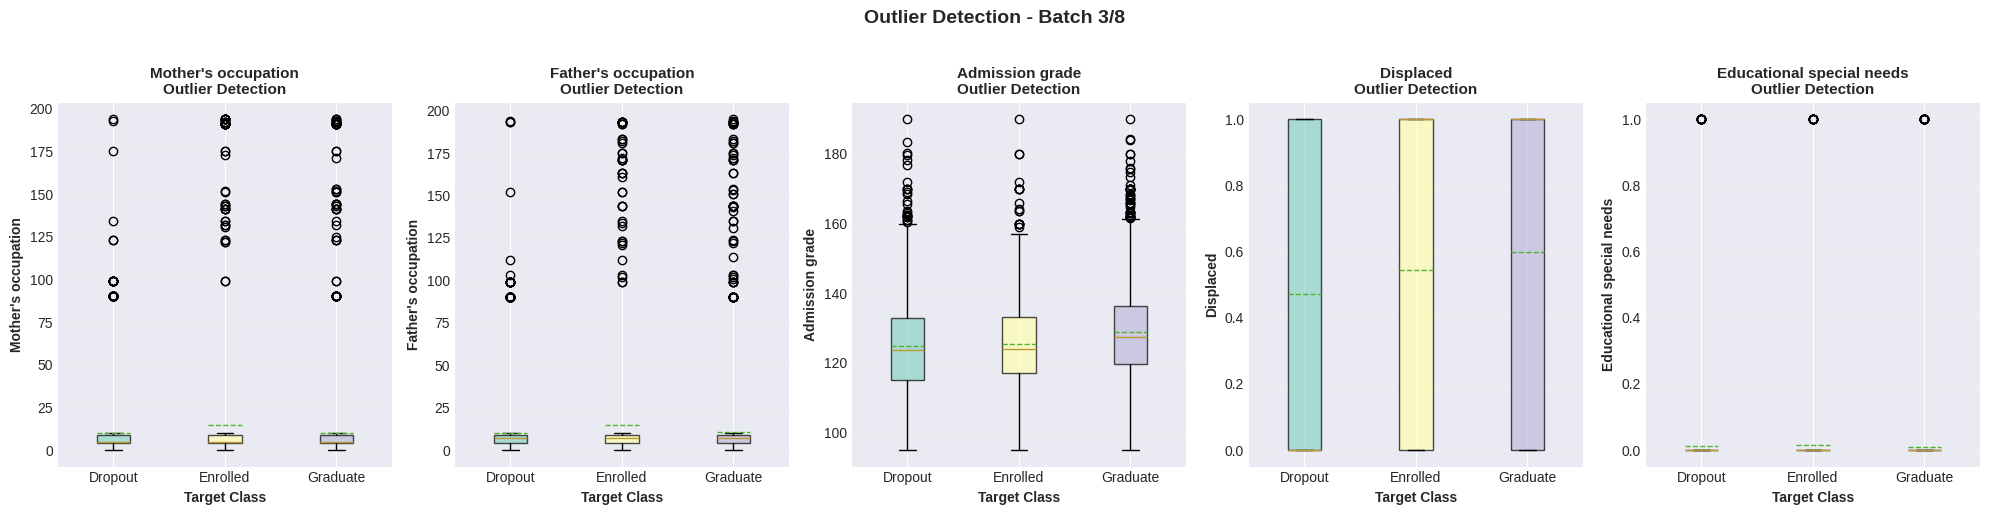

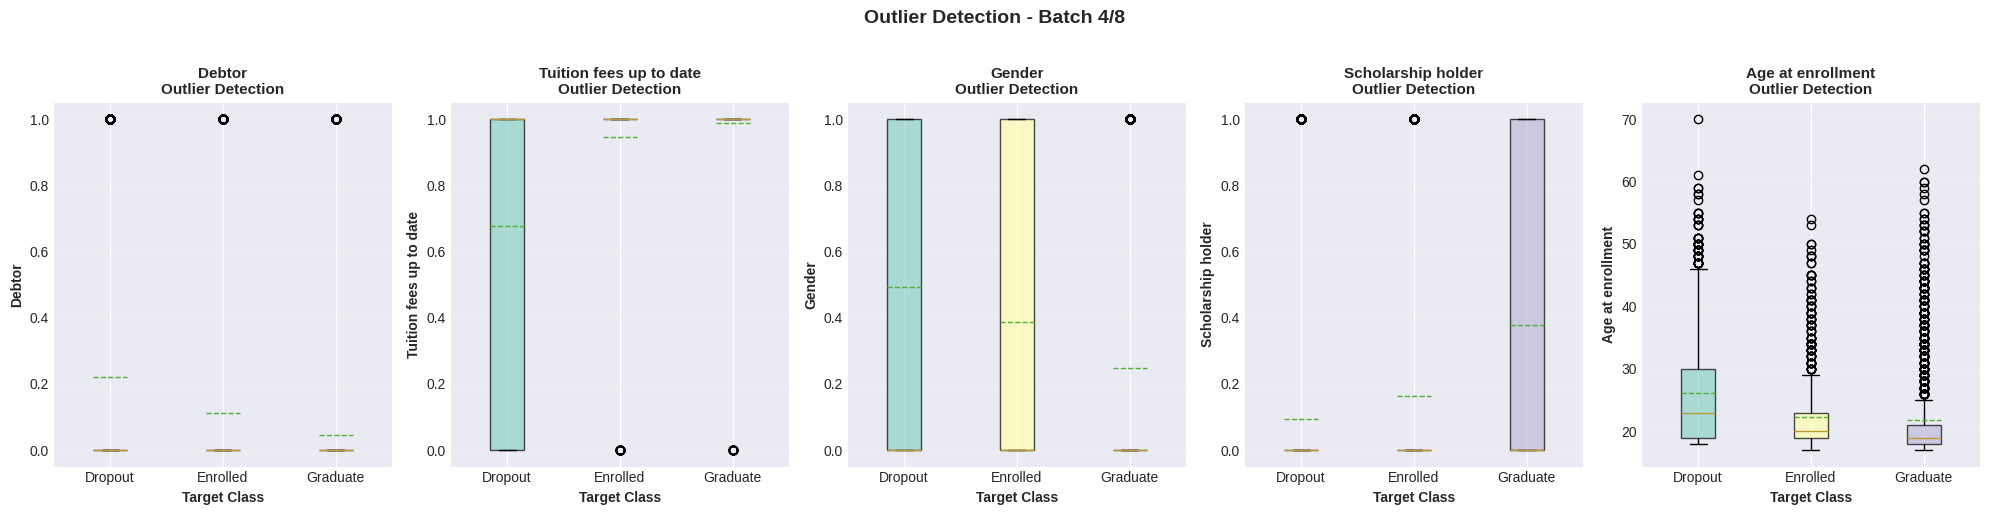

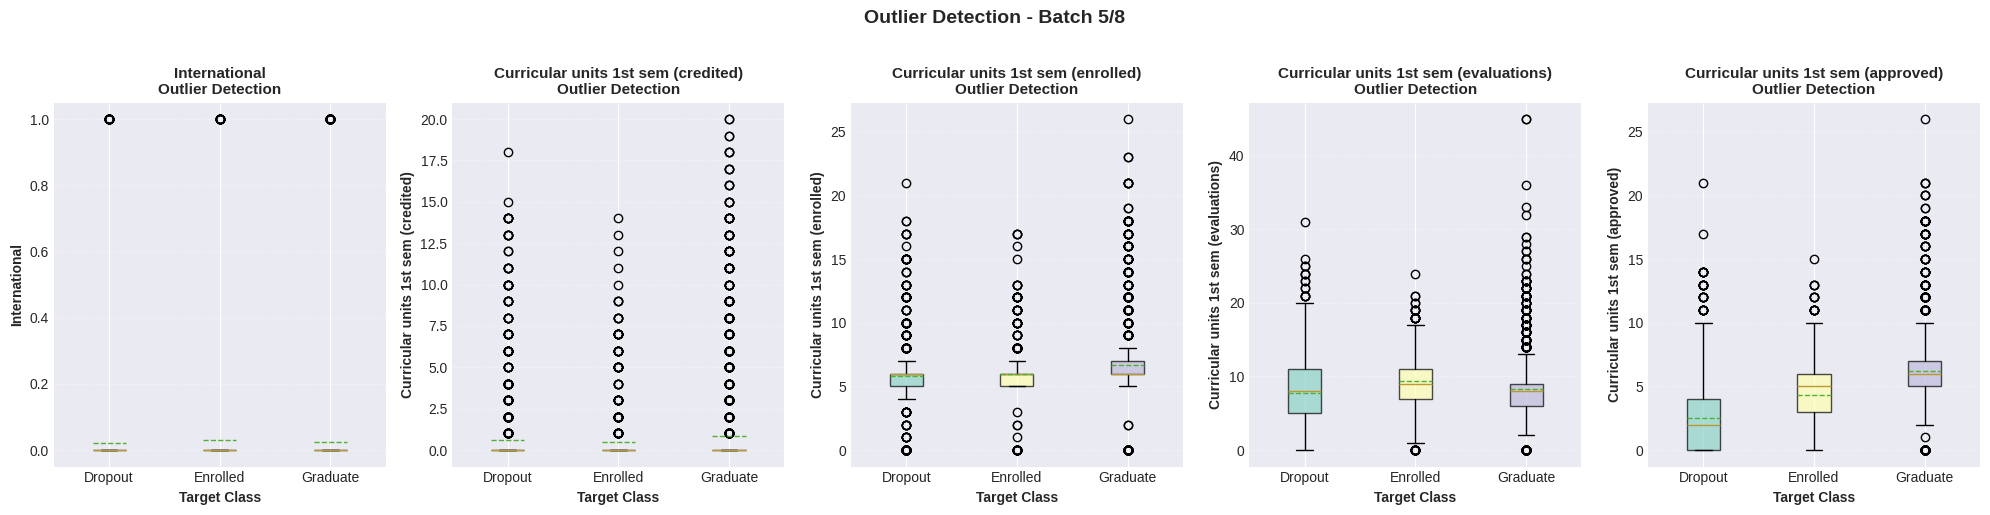

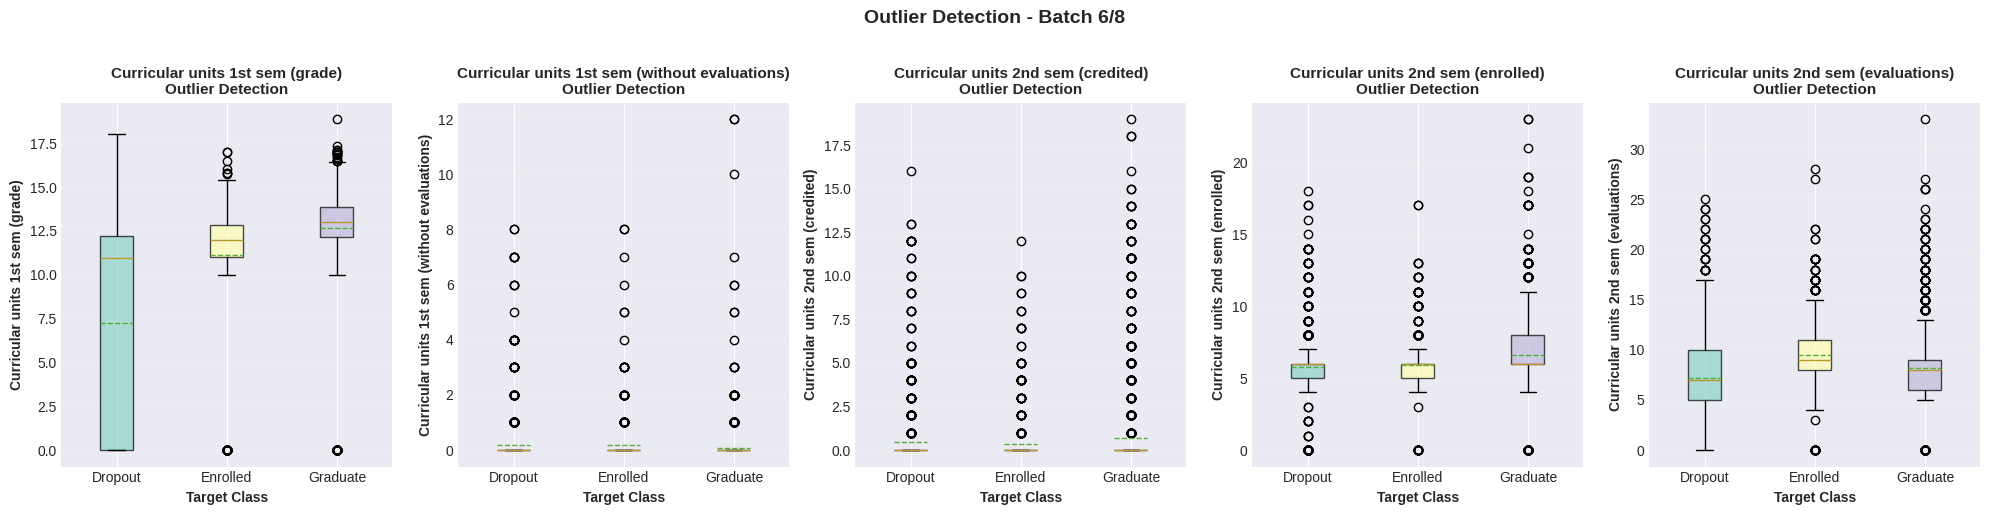

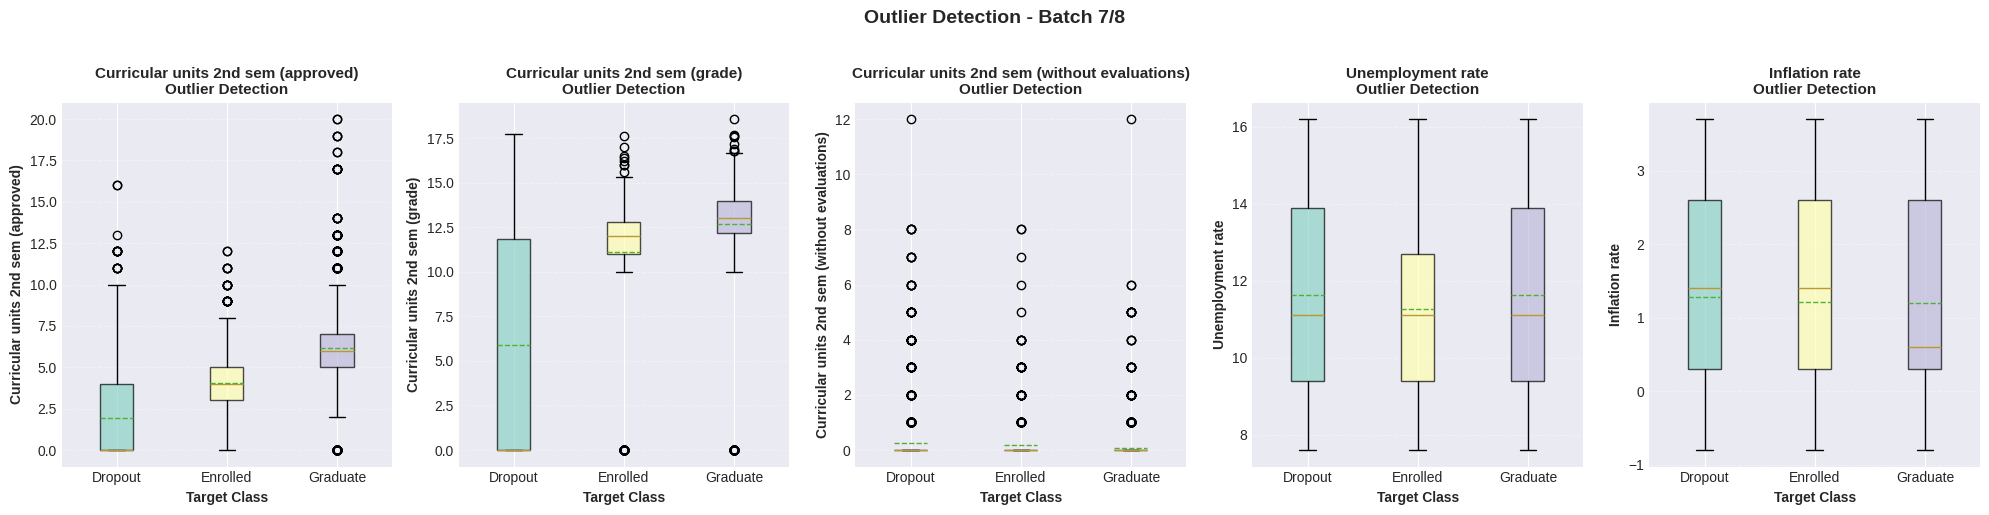

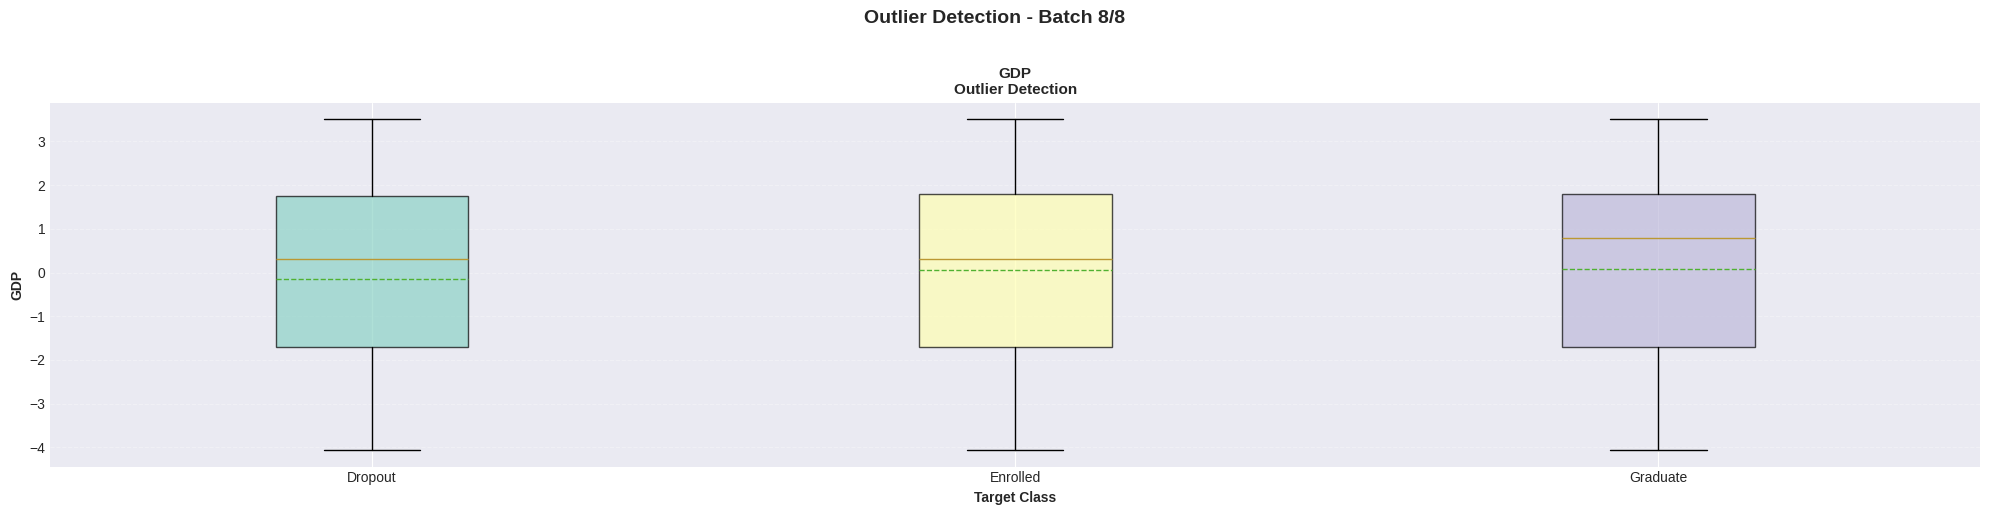


📋 OUTLIER SUMMARY TABLE:
--------------------------------------------------------------------------------
                                       Feature    Class  N_Outliers  Outlier_Pct  Lower_Bound  Upper_Bound
                                Marital status  Dropout         237        16.68         1.00         1.00
                                Marital status Enrolled          74         9.32         1.00         1.00
                                Marital status Graduate         194         8.78         1.00         1.00
                              Application mode  Dropout           0         0.00       -41.00        87.00
                              Application mode Enrolled           0         0.00       -56.00        96.00
                              Application mode Graduate         142         6.43       -24.50        43.50
                             Application order  Dropout         142         9.99        -0.50         3.50
                             Applicat

In [14]:
# ═══════════════════════════════════════════════════════════════════════════════
# EXECUTE SECTION 2C - COMPREHENSIVE NUMERIC FEATURE ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SECTION 2C: NUMERIC FEATURES DEEP ANALYSIS")
print("="*80)

# Initialize analyzer (using target_column from Section 2B)
numeric_analyzer = NumericFeatureAnalyzer(df, target_column)

# Step 1: Descriptive Statistics
print("\n📊 STEP 1: Comprehensive Descriptive Statistics")
print("-" * 80)
desc_stats = numeric_analyzer.descriptive_statistics()

# Step 2: Distribution Analysis by Target
print("\n📈 STEP 2: Feature Distributions by Target Class")
print("-" * 80)
print("Generating distribution plots...")
numeric_analyzer.distribution_by_target(n_cols=4, figsize=(20, 5))

# Step 3: Statistical Significance Testing
print("\n📊 STEP 3: Statistical Significance Testing")
print("-" * 80)
significance_results = numeric_analyzer.statistical_significance_tests()

# Step 4: Outlier Analysis
print("\n📦 STEP 4: Outlier Detection & Analysis")
print("-" * 80)
print("Generating box plots for outlier detection...")
outlier_results = numeric_analyzer.outlier_analysis(figsize=(20, 5))

# Final Summary
print("\n" + "="*80)
print("✅ SECTION 2C COMPLETE!")
print("="*80)
print("\n🎯 KEY FINDINGS:")
print("-" * 80)

if desc_stats is not None:
    # Highly skewed features
    skewed_features = desc_stats[abs(desc_stats['skewness']) > 1].index.tolist()
    if skewed_features:
        print(f"  • {len(skewed_features)} features are highly skewed (may need transformation)")

    # Features with missing values
    missing_features = desc_stats[desc_stats['missing'] > 0]
    if len(missing_features) > 0:
        print(f"  • {len(missing_features)} features have missing values")

if significance_results is not None:
    n_significant = len(significance_results[significance_results['Significant'] != 'ns'])
    print(f"  • {n_significant} features show statistically significant differences")

if outlier_results is not None:
    total_outliers = outlier_results['N_Outliers'].sum()
    print(f"  • {total_outliers:,} total outliers detected across all features")

print("\n🚀 Ready for Section 2D: Correlation & Feature Relationships")
print("="*80)


SECTION 2D: CORRELATION ANALYSIS & FEATURE RELATIONSHIPS
✓ Initialized with 36 numeric features for correlation analysis

📊 STEP 1: Correlation Matrix Visualization
--------------------------------------------------------------------------------

📊 CORRELATION MATRIX ANALYSIS (PEARSON METHOD)


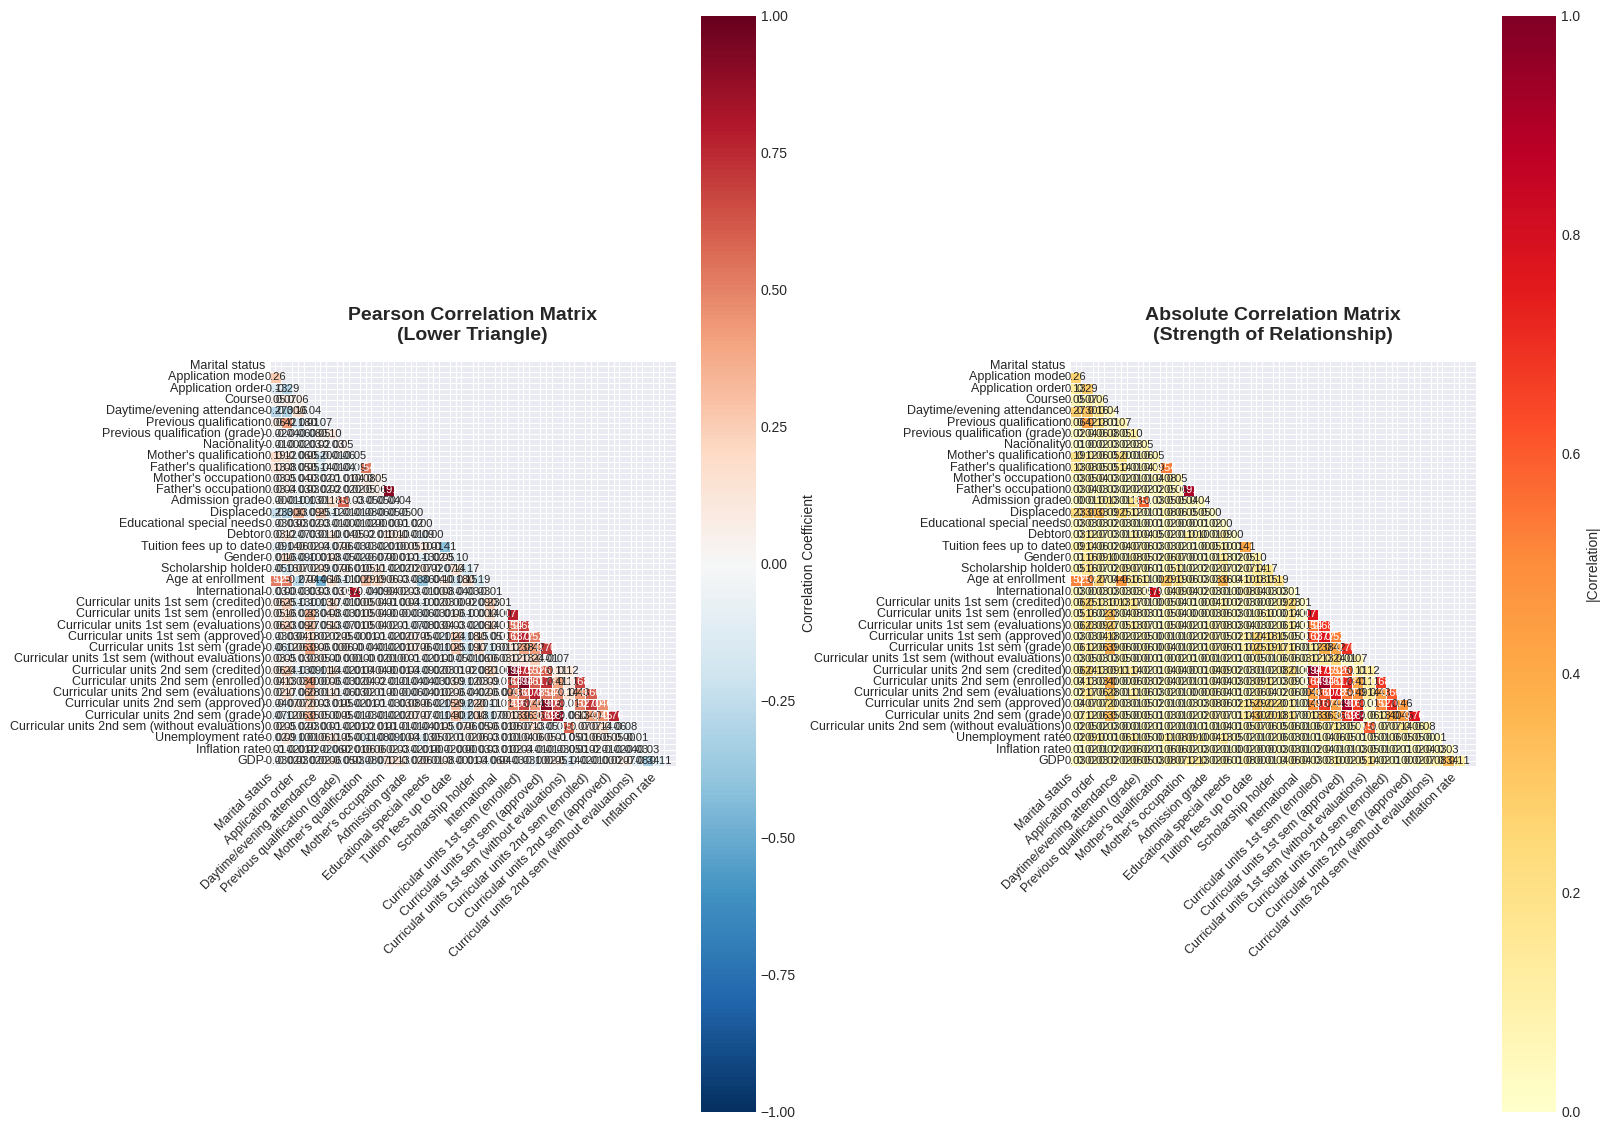


✓ Correlation matrix computed using pearson method


🔍 STEP 2: High Correlation Detection
--------------------------------------------------------------------------------

🔍 HIGH CORRELATION DETECTION (|r| > 0.7)

⚠️  Found 13 highly correlated pairs:
--------------------------------------------------------------------------------
                             Feature_1                              Feature_2  Correlation  Abs_Correlation Relationship
   Curricular units 1st sem (credited)    Curricular units 2nd sem (credited)       0.9448           0.9448     Positive
   Curricular units 1st sem (enrolled)    Curricular units 2nd sem (enrolled)       0.9426           0.9426     Positive
                   Mother's occupation                    Father's occupation       0.9105           0.9105     Positive
   Curricular units 1st sem (approved)    Curricular units 2nd sem (approved)       0.9040           0.9040     Positive
      Curricular units 1st sem (grade)       Curricular units

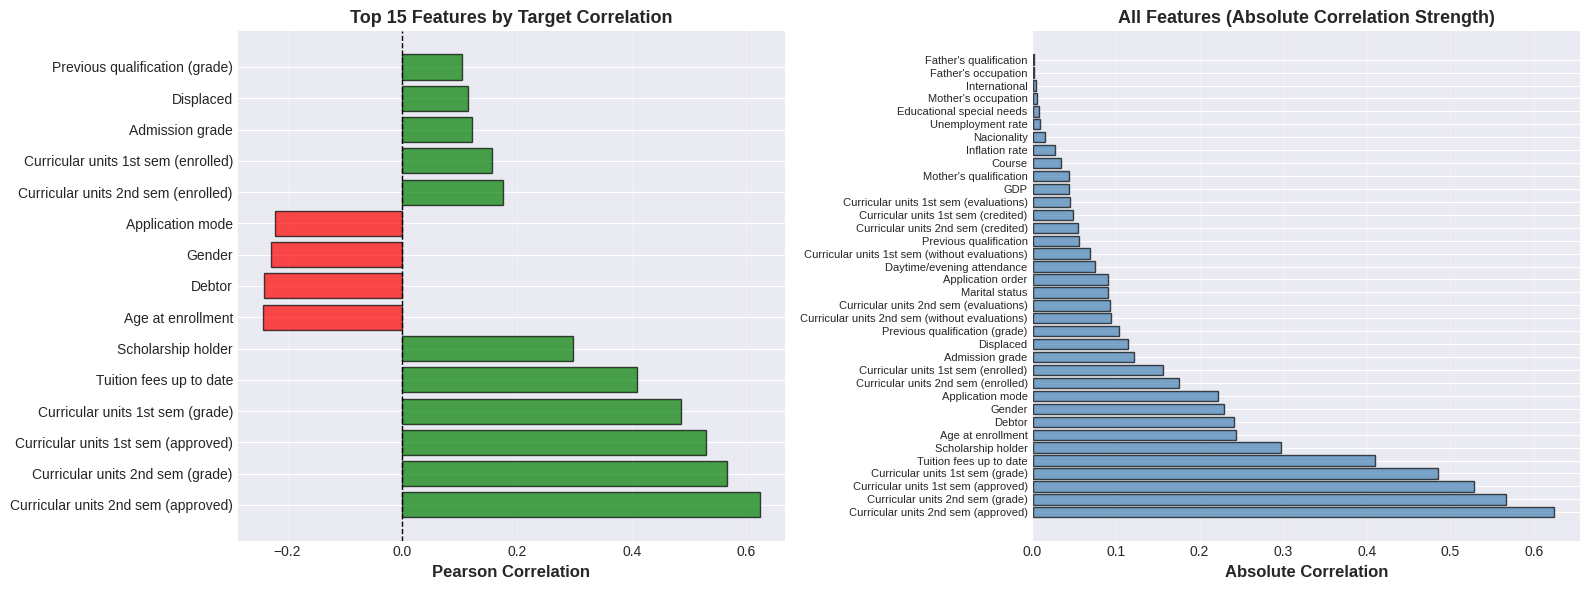


--------------------------------------------------------------------------------
📈 CORRELATION SUMMARY:
   • Strongest positive correlation: Curricular units 2nd sem (approved) (r = 0.6242)
   • Strongest negative correlation: Age at enrollment (r = -0.2434)
   • Significant correlations: 28/36 features
   • Weak correlations (|r| < 0.1): 21 features
     → Consider removing: Curricular units 2nd sem (without evaluations), Curricular units 2nd sem (evaluations), Marital status, Application order, Daytime/evening attendance


📊 STEP 4: Variance Inflation Factor (VIF) Analysis
--------------------------------------------------------------------------------

📊 VARIANCE INFLATION FACTOR (VIF) ANALYSIS

Calculating VIF for 36 features...
(This may take a moment for large datasets)
--------------------------------------------------------------------------------

                                       Feature      VIF Multicollinearity
           Curricular units 1st sem (enrolled) 180.7868 

In [15]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 2D: CORRELATION ANALYSIS & FEATURE RELATIONSHIPS
# Purpose: Identify multicollinearity, feature redundancy, and relationships
# Essential for feature selection and model interpretability
# ═══════════════════════════════════════════════════════════════════════════════

class CorrelationAnalyzer:
    """
    Publication-grade correlation and feature relationship analysis

    Features:
    - Correlation matrix with multiple methods
    - Multicollinearity detection (VIF)
    - High correlation identification
    - Feature clustering
    - Target correlation ranking
    """

    def __init__(self, df, target_col):
        """
        Initialize analyzer

        Parameters:
        -----------
        df : pandas.DataFrame
            The dataset
        target_col : str
            Name of the target variable
        """
        self.df = df.copy()
        self.target_col = target_col
        self.numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

        # Remove target if it's numeric
        if target_col in self.numeric_cols:
            self.numeric_cols.remove(target_col)

        self.n_features = len(self.numeric_cols)
        print(f"✓ Initialized with {self.n_features} numeric features for correlation analysis")

    def correlation_matrix_analysis(self, method='pearson', figsize=(16, 14)):
        """
        Create comprehensive correlation matrix with publication-quality visualization

        Parameters:
        -----------
        method : str
            Correlation method: 'pearson', 'spearman', or 'kendall'
        """

        print("\n" + "="*80)
        print(f"📊 CORRELATION MATRIX ANALYSIS ({method.upper()} METHOD)")
        print("="*80)

        if self.n_features < 2:
            print("Need at least 2 numeric features for correlation analysis.")
            return None

        # Compute correlation matrix
        corr_matrix = self.df[self.numeric_cols].corr(method=method)

        # Create figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # Plot 1: Full correlation matrix
        ax1 = axes[0]
        mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

        sns.heatmap(corr_matrix, mask=mask_upper, annot=True, fmt='.2f',
                   cmap='RdBu_r', center=0, square=True, linewidths=0.5,
                   cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
                   ax=ax1, vmin=-1, vmax=1, annot_kws={"size": 8})

        ax1.set_title(f'{method.capitalize()} Correlation Matrix\n(Lower Triangle)',
                     fontsize=14, fontweight='bold', pad=15)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=9)
        ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=9)

        # Plot 2: Absolute correlation values (for identifying strong relationships)
        ax2 = axes[1]
        abs_corr = corr_matrix.abs()

        sns.heatmap(abs_corr, mask=mask_upper, annot=True, fmt='.2f',
                   cmap='YlOrRd', square=True, linewidths=0.5,
                   cbar_kws={"shrink": 0.8, "label": "|Correlation|"},
                   ax=ax2, vmin=0, vmax=1, annot_kws={"size": 8})

        ax2.set_title(f'Absolute Correlation Matrix\n(Strength of Relationship)',
                     fontsize=14, fontweight='bold', pad=15)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9)
        ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=9)

        plt.tight_layout()
        plt.show()

        print(f"\n✓ Correlation matrix computed using {method} method")
        print("="*80 + "\n")

        return corr_matrix

    def identify_high_correlations(self, corr_matrix, threshold=0.7):
        """
        Identify highly correlated feature pairs (potential multicollinearity)
        Critical for feature selection

        Parameters:
        -----------
        corr_matrix : pandas.DataFrame
            Correlation matrix
        threshold : float
            Correlation threshold (default: 0.7)
        """

        print("\n" + "="*80)
        print(f"🔍 HIGH CORRELATION DETECTION (|r| > {threshold})")
        print("="*80)

        high_corr_pairs = []

        # Find pairs with correlation above threshold
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_value = corr_matrix.iloc[i, j]
                if abs(corr_value) > threshold:
                    high_corr_pairs.append({
                        'Feature_1': corr_matrix.columns[i],
                        'Feature_2': corr_matrix.columns[j],
                        'Correlation': round(corr_value, 4),
                        'Abs_Correlation': round(abs(corr_value), 4),
                        'Relationship': 'Positive' if corr_value > 0 else 'Negative'
                    })

        if high_corr_pairs:
            high_corr_df = pd.DataFrame(high_corr_pairs)
            high_corr_df = high_corr_df.sort_values('Abs_Correlation', ascending=False)

            print(f"\n⚠️  Found {len(high_corr_pairs)} highly correlated pairs:")
            print("-" * 80)
            print(high_corr_df.to_string(index=False))

            print("\n" + "-"*80)
            print("💡 RECOMMENDATION:")
            print("   High correlation (|r| > 0.7) indicates potential multicollinearity.")
            print("   Consider:")
            print("   1. Remove one feature from each highly correlated pair")
            print("   2. Combine correlated features (e.g., PCA)")
            print("   3. Use regularization (Ridge/Lasso regression)")
            print("="*80 + "\n")

            return high_corr_df
        else:
            print(f"\n✓ No feature pairs with |correlation| > {threshold}")
            print("   Dataset shows good feature independence!")
            print("="*80 + "\n")
            return None

    def target_correlation_ranking(self, method='pearson'):
        """
        Rank features by correlation with target variable
        Identifies most predictive features
        """

        print("\n" + "="*80)
        print(f"🎯 FEATURE-TARGET CORRELATION RANKING")
        print("="*80)

        # Check if target is numeric (for correlation)
        if self.df[self.target_col].dtype not in [np.int64, np.float64]:
            print("\n⚠️  Target variable is categorical. Converting to numeric for correlation...")
            # Label encode target for correlation analysis
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            target_numeric = le.fit_transform(self.df[self.target_col])
            print(f"   Classes: {dict(zip(le.classes_, le.transform(le.classes_)))}")
        else:
            target_numeric = self.df[self.target_col]

        # Compute correlations with target
        target_corrs = []
        for feature in self.numeric_cols:
            if method == 'pearson':
                corr, p_value = stats.pearsonr(self.df[feature].dropna(),
                                              target_numeric[self.df[feature].notna()])
            elif method == 'spearman':
                corr, p_value = stats.spearmanr(self.df[feature].dropna(),
                                               target_numeric[self.df[feature].notna()])
            else:
                corr, p_value = stats.kendalltau(self.df[feature].dropna(),
                                                target_numeric[self.df[feature].notna()])

            target_corrs.append({
                'Feature': feature,
                'Correlation': round(corr, 4),
                'Abs_Correlation': round(abs(corr), 4),
                'p_value': round(p_value, 6),
                'Significant': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
            })

        target_corr_df = pd.DataFrame(target_corrs)
        target_corr_df = target_corr_df.sort_values('Abs_Correlation', ascending=False)

        print(f"\n📊 Features ranked by correlation with '{self.target_col}':")
        print("-" * 80)
        print(target_corr_df.to_string(index=False))

        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Plot 1: Top correlations
        ax1 = axes[0]
        top_n = min(15, len(target_corr_df))
        top_features = target_corr_df.head(top_n)

        colors = ['green' if x > 0 else 'red' for x in top_features['Correlation']]
        ax1.barh(range(top_n), top_features['Correlation'], color=colors, alpha=0.7, edgecolor='black')
        ax1.set_yticks(range(top_n))
        ax1.set_yticklabels(top_features['Feature'], fontsize=10)
        ax1.set_xlabel(f'{method.capitalize()} Correlation', fontsize=12, fontweight='bold')
        ax1.set_title(f'Top {top_n} Features by Target Correlation', fontsize=13, fontweight='bold')
        ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
        ax1.grid(alpha=0.3, axis='x')

        # Plot 2: All features (absolute correlation)
        ax2 = axes[1]
        ax2.barh(range(len(target_corr_df)), target_corr_df['Abs_Correlation'],
                alpha=0.7, edgecolor='black', color='steelblue')
        ax2.set_yticks(range(len(target_corr_df)))
        ax2.set_yticklabels(target_corr_df['Feature'], fontsize=8)
        ax2.set_xlabel('Absolute Correlation', fontsize=12, fontweight='bold')
        ax2.set_title('All Features (Absolute Correlation Strength)', fontsize=13, fontweight='bold')
        ax2.grid(alpha=0.3, axis='x')

        plt.tight_layout()
        plt.show()

        # Summary statistics
        print("\n" + "-"*80)
        print("📈 CORRELATION SUMMARY:")
        print(f"   • Strongest positive correlation: {target_corr_df.iloc[0]['Feature']} (r = {target_corr_df.iloc[0]['Correlation']})")

        strongest_negative = target_corr_df[target_corr_df['Correlation'] < 0].head(1)
        if not strongest_negative.empty:
            print(f"   • Strongest negative correlation: {strongest_negative.iloc[0]['Feature']} (r = {strongest_negative.iloc[0]['Correlation']})")

        significant_features = target_corr_df[target_corr_df['Significant'] != 'ns']
        print(f"   • Significant correlations: {len(significant_features)}/{len(target_corr_df)} features")

        weak_features = target_corr_df[target_corr_df['Abs_Correlation'] < 0.1]
        if not weak_features.empty:
            print(f"   • Weak correlations (|r| < 0.1): {len(weak_features)} features")
            print(f"     → Consider removing: {', '.join(weak_features['Feature'].head(5).tolist())}")

        print("="*80 + "\n")

        return target_corr_df

    def variance_inflation_factor(self):
        """
        Calculate VIF for multicollinearity detection
        VIF > 10 indicates serious multicollinearity
        VIF > 5 indicates moderate multicollinearity
        """

        print("\n" + "="*80)
        print("📊 VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
        print("="*80)

        if self.n_features < 2:
            print("Need at least 2 features for VIF calculation.")
            return None

        from statsmodels.stats.outliers_influence import variance_inflation_factor

        # Prepare data (remove missing values)
        X = self.df[self.numeric_cols].dropna()

        if len(X) == 0:
            print("⚠️  No complete cases available after removing missing values.")
            return None

        print(f"\nCalculating VIF for {len(self.numeric_cols)} features...")
        print("(This may take a moment for large datasets)")
        print("-" * 80)

        vif_data = []
        for i, feature in enumerate(self.numeric_cols):
            try:
                vif = variance_inflation_factor(X.values, i)
                vif_data.append({
                    'Feature': feature,
                    'VIF': round(vif, 4),
                    'Multicollinearity': 'Severe' if vif > 10 else 'Moderate' if vif > 5 else 'Low'
                })
            except Exception as e:
                print(f"   ⚠️  Could not calculate VIF for {feature}: {str(e)}")
                vif_data.append({
                    'Feature': feature,
                    'VIF': np.nan,
                    'Multicollinearity': 'Error'
                })

        vif_df = pd.DataFrame(vif_data)
        vif_df = vif_df.sort_values('VIF', ascending=False)

        print("\n" + vif_df.to_string(index=False))

        print("\n" + "-"*80)
        print("📖 VIF INTERPRETATION:")
        print("   • VIF = 1: No correlation with other features")
        print("   • VIF < 5: Low multicollinearity (acceptable)")
        print("   • 5 ≤ VIF ≤ 10: Moderate multicollinearity (caution)")
        print("   • VIF > 10: Severe multicollinearity (problematic)")

        severe = vif_df[vif_df['Multicollinearity'] == 'Severe']
        moderate = vif_df[vif_df['Multicollinearity'] == 'Moderate']

        if not severe.empty:
            print(f"\n⚠️  SEVERE MULTICOLLINEARITY detected in {len(severe)} feature(s):")
            print(f"   {', '.join(severe['Feature'].tolist())}")
            print("   → Consider removing these features or using PCA")

        if not moderate.empty:
            print(f"\n⚠️  MODERATE MULTICOLLINEARITY in {len(moderate)} feature(s):")
            print(f"   {', '.join(moderate['Feature'].tolist())}")

        if severe.empty and moderate.empty:
            print("\n✓ No significant multicollinearity detected!")

        print("="*80 + "\n")

        return vif_df


# ═══════════════════════════════════════════════════════════════════════════════
# EXECUTE SECTION 2D - CORRELATION & FEATURE RELATIONSHIPS ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SECTION 2D: CORRELATION ANALYSIS & FEATURE RELATIONSHIPS")
print("="*80)

# Initialize analyzer
corr_analyzer = CorrelationAnalyzer(df, target_column)

# Step 1: Correlation Matrix Analysis
print("\n📊 STEP 1: Correlation Matrix Visualization")
print("-" * 80)
corr_matrix = corr_analyzer.correlation_matrix_analysis(method='pearson', figsize=(16, 14))

# Step 2: Identify High Correlations
print("\n🔍 STEP 2: High Correlation Detection")
print("-" * 80)
high_corr_pairs = corr_analyzer.identify_high_correlations(corr_matrix, threshold=0.7)

# Step 3: Feature-Target Correlation Ranking
print("\n🎯 STEP 3: Feature-Target Correlation Analysis")
print("-" * 80)
target_corr_ranking = corr_analyzer.target_correlation_ranking(method='pearson')

# Step 4: VIF Analysis for Multicollinearity
print("\n📊 STEP 4: Variance Inflation Factor (VIF) Analysis")
print("-" * 80)
vif_results = corr_analyzer.variance_inflation_factor()

# Final Summary
print("\n" + "="*80)
print("✅ SECTION 2D COMPLETE!")
print("="*80)
print("\n🎯 KEY INSIGHTS:")
print("-" * 80)

if high_corr_pairs is not None:
    print(f"  • {len(high_corr_pairs)} highly correlated feature pairs detected")
    print("    → May indicate redundant features")
else:
    print("  • No highly correlated pairs (good feature independence)")

if target_corr_ranking is not None:
    top_feature = target_corr_ranking.iloc[0]
    print(f"  • Most predictive feature: '{top_feature['Feature']}' (r = {top_feature['Correlation']})")

    weak_features = target_corr_ranking[target_corr_ranking['Abs_Correlation'] < 0.1]
    if not weak_features.empty:
        print(f"  • {len(weak_features)} features show weak correlation with target")

if vif_results is not None:
    severe_vif = vif_results[vif_results['Multicollinearity'] == 'Severe']
    if not severe_vif.empty:
        print(f"  • {len(severe_vif)} features show severe multicollinearity (VIF > 10)")
    else:
        print("  • No severe multicollinearity issues detected")

print("\n💡 RECOMMENDATIONS:")
print("   1. Consider removing one feature from highly correlated pairs")
print("   2. Focus on features with strong target correlation for modeling")
print("   3. Address multicollinearity using regularization or dimensionality reduction")

print("\n🚀 Ready for Section 3: Feature Engineering & Preprocessing")
print("="*80)

In [16]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 3A: MISSING VALUE ANALYSIS & ADVANCED IMPUTATION
# Purpose: Systematic handling of missing data with multiple strategies
# Essential for maintaining data integrity in publication-grade research
# ═══════════════════════════════════════════════════════════════════════════════

class MissingValueHandler:
    """
    Publication-grade missing value analysis and imputation

    Features:
    - Comprehensive missing value pattern analysis
    - Multiple imputation strategies
    - Impact assessment before/after imputation
    - Statistical validation of imputation quality
    """

    def __init__(self, df, target_col):
        """
        Initialize handler

        Parameters:
        -----------
        df : pandas.DataFrame
            The dataset
        target_col : str
            Name of the target variable
        """
        self.df = df.copy()
        self.df_imputed = None
        self.target_col = target_col
        self.missing_summary = None
        self.imputation_report = {}

        print(f"✓ Initialized Missing Value Handler")
        print(f"  Dataset shape: {self.df.shape}")

    def analyze_missing_patterns(self):
        """
        Comprehensive analysis of missing value patterns
        Essential for understanding data quality issues
        """

        print("\n" + "="*80)
        print("🔍 MISSING VALUE PATTERN ANALYSIS")
        print("="*80)

        # Calculate missing statistics
        total_cells = self.df.shape[0] * self.df.shape[1]
        total_missing = self.df.isnull().sum().sum()
        missing_pct = (total_missing / total_cells) * 100

        print(f"\n📊 Overall Missing Data Statistics:")
        print("-" * 80)
        print(f"  Total cells: {total_cells:,}")
        print(f"  Missing cells: {total_missing:,}")
        print(f"  Missing percentage: {missing_pct:.2f}%")

        # Per-column analysis
        missing_cols = self.df.isnull().sum()
        missing_cols = missing_cols[missing_cols > 0].sort_values(ascending=False)

        if len(missing_cols) == 0:
            print("\n✓ No missing values detected in dataset!")
            print("="*80 + "\n")
            return None

        print(f"\n📋 Columns with Missing Values: {len(missing_cols)}/{len(self.df.columns)}")
        print("-" * 80)

        missing_data = []
        for col in missing_cols.index:
            count = missing_cols[col]
            pct = (count / len(self.df)) * 100
            dtype = self.df[col].dtype

            missing_data.append({
                'Column': col,
                'Missing_Count': count,
                'Missing_Pct': round(pct, 2),
                'Data_Type': str(dtype),
                'Strategy': self._recommend_strategy(pct, dtype)
            })

        self.missing_summary = pd.DataFrame(missing_data)
        print(self.missing_summary.to_string(index=False))

        # Visualization
        self._plot_missing_patterns(missing_cols)

        print("\n" + "="*80 + "\n")
        return self.missing_summary

    def _recommend_strategy(self, missing_pct, dtype):
        """Recommend imputation strategy based on missing percentage and data type"""
        if missing_pct > 50:
            return "Consider Dropping"
        elif missing_pct > 30:
            return "Advanced Imputation"
        elif missing_pct > 10:
            return "Model-based"
        else:
            if 'int' in str(dtype) or 'float' in str(dtype):
                return "Median/Mean"
            else:
                return "Mode"

    def _plot_missing_patterns(self, missing_cols):
        """Create publication-quality visualization of missing patterns"""

        if len(missing_cols) == 0:
            return

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Plot 1: Missing value counts
        ax1 = axes[0]
        top_n = min(20, len(missing_cols))
        colors = plt.cm.Reds(np.linspace(0.4, 0.9, top_n))

        y_pos = np.arange(top_n)
        ax1.barh(y_pos, missing_cols.head(top_n).values, color=colors,
                edgecolor='black', linewidth=1)
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(missing_cols.head(top_n).index, fontsize=10)
        ax1.set_xlabel('Number of Missing Values', fontsize=12, fontweight='bold')
        ax1.set_title(f'Top {top_n} Columns by Missing Count',
                     fontsize=13, fontweight='bold')
        ax1.grid(alpha=0.3, axis='x', linestyle='--')

        # Add value labels
        for i, v in enumerate(missing_cols.head(top_n).values):
            pct = (v / len(self.df)) * 100
            ax1.text(v + max(missing_cols.head(top_n).values)*0.01, i,
                    f'{int(v)} ({pct:.1f}%)',
                    va='center', fontsize=9, fontweight='bold')

        # Plot 2: Missing value heatmap (sample of rows)
        ax2 = axes[1]

        # Select columns with missing values and sample rows
        cols_with_missing = missing_cols.head(top_n).index.tolist()
        sample_size = min(100, len(self.df))
        sample_df = self.df[cols_with_missing].sample(n=sample_size, random_state=42)

        # Create binary matrix (1 = missing, 0 = present)
        missing_matrix = sample_df.isnull().astype(int)

        sns.heatmap(missing_matrix.T, cmap=['lightblue', 'darkred'],
                   cbar_kws={'label': 'Missing (1) / Present (0)'},
                   ax=ax2, yticklabels=True)
        ax2.set_xlabel('Sample Rows', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Features', fontsize=12, fontweight='bold')
        ax2.set_title(f'Missing Value Pattern\n(Sample of {sample_size} rows)',
                     fontsize=13, fontweight='bold')

        plt.tight_layout()
        plt.show()

    def impute_missing_values(self, strategy='auto'):
        """
        Apply intelligent imputation strategies

        Parameters:
        -----------
        strategy : str
            'auto' : Automatically select best strategy per column
            'mean' : Mean imputation for numeric
            'median' : Median imputation for numeric
            'mode' : Mode imputation for categorical
            'knn' : KNN imputation
            'iterative' : Iterative imputation (MICE-like)
        """

        print("\n" + "="*80)
        print(f"🔧 MISSING VALUE IMPUTATION (Strategy: {strategy.upper()})")
        print("="*80)

        if self.df.isnull().sum().sum() == 0:
            print("\n✓ No missing values to impute!")
            self.df_imputed = self.df.copy()
            return self.df_imputed

        self.df_imputed = self.df.copy()

        numeric_cols = self.df_imputed.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = self.df_imputed.select_dtypes(include=['object', 'category']).columns.tolist()

        # Remove target from imputation columns
        if self.target_col in numeric_cols:
            numeric_cols.remove(self.target_col)
        if self.target_col in categorical_cols:
            categorical_cols.remove(self.target_col)

        imputation_log = []

        # Impute numeric columns
        if strategy == 'auto' or strategy in ['mean', 'median', 'knn', 'iterative']:
            for col in numeric_cols:
                if self.df_imputed[col].isnull().sum() > 0:
                    missing_count = self.df_imputed[col].isnull().sum()
                    missing_pct = (missing_count / len(self.df_imputed)) * 100

                    if strategy == 'auto':
                        # Auto-select strategy based on missing percentage
                        if missing_pct > 30:
                            chosen_strategy = 'median'
                        elif missing_pct > 10:
                            chosen_strategy = 'median'
                        else:
                            chosen_strategy = 'median'
                    else:
                        chosen_strategy = strategy

                    # Apply imputation
                    if chosen_strategy == 'mean':
                        fill_value = self.df_imputed[col].mean()
                        self.df_imputed[col].fillna(fill_value, inplace=True)
                    elif chosen_strategy == 'median':
                        fill_value = self.df_imputed[col].median()
                        self.df_imputed[col].fillna(fill_value, inplace=True)

                    imputation_log.append({
                        'Column': col,
                        'Type': 'Numeric',
                        'Missing_Count': missing_count,
                        'Missing_Pct': round(missing_pct, 2),
                        'Strategy': chosen_strategy,
                        'Fill_Value': round(fill_value, 4) if 'fill_value' in locals() else 'N/A'
                    })

        # Impute categorical columns
        for col in categorical_cols:
            if self.df_imputed[col].isnull().sum() > 0:
                missing_count = self.df_imputed[col].isnull().sum()
                missing_pct = (missing_count / len(self.df_imputed)) * 100

                # Mode imputation for categorical
                mode_value = self.df_imputed[col].mode()
                if len(mode_value) > 0:
                    fill_value = mode_value[0]
                    self.df_imputed[col].fillna(fill_value, inplace=True)

                    imputation_log.append({
                        'Column': col,
                        'Type': 'Categorical',
                        'Missing_Count': missing_count,
                        'Missing_Pct': round(missing_pct, 2),
                        'Strategy': 'mode',
                        'Fill_Value': fill_value
                    })

        # Create imputation report
        imputation_df = pd.DataFrame(imputation_log)

        print("\n📋 Imputation Summary:")
        print("-" * 80)
        if len(imputation_log) > 0:
            print(imputation_df.to_string(index=False))
        else:
            print("No imputation performed.")

        print("\n" + "-"*80)
        print("✓ Imputation complete!")
        print(f"  Remaining missing values: {self.df_imputed.isnull().sum().sum()}")
        print("="*80 + "\n")

        self.imputation_report = imputation_df
        return self.df_imputed

    def validate_imputation(self):
        """
        Validate imputation quality by comparing distributions
        Critical for publication - shows imputation didn't distort data
        """

        print("\n" + "="*80)
        print("📊 IMPUTATION QUALITY VALIDATION")
        print("="*80)

        if self.df_imputed is None:
            print("\n⚠️  No imputation performed yet. Run impute_missing_values() first.")
            return

        if self.imputation_report is None or len(self.imputation_report) == 0:
            print("\n✓ No imputation was needed (no missing values)")
            return

        print("\nComparing distributions before and after imputation...")
        print("-" * 80)

        # Get numeric columns that were imputed
        imputed_numeric = self.imputation_report[
            self.imputation_report['Type'] == 'Numeric'
        ]['Column'].tolist()

        if len(imputed_numeric) == 0:
            print("No numeric columns were imputed.")
            return

        # Plot distributions
        n_cols = min(3, len(imputed_numeric))
        n_rows = int(np.ceil(len(imputed_numeric) / n_cols))

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        else:
            axes = axes.flatten()

        validation_stats = []

        for idx, col in enumerate(imputed_numeric[:15]):  # Limit to 15 for clarity
            ax = axes[idx]

            # Original data (non-missing values)
            original_data = self.df[col].dropna()

            # Imputed data (all values)
            imputed_data = self.df_imputed[col]

            # Plot histograms
            ax.hist(original_data, bins=30, alpha=0.6, label='Original (non-missing)',
                   color='blue', edgecolor='black', density=True)
            ax.hist(imputed_data, bins=30, alpha=0.6, label='After Imputation (all)',
                   color='red', edgecolor='black', density=True)

            ax.set_xlabel(col, fontsize=10, fontweight='bold')
            ax.set_ylabel('Density', fontsize=10, fontweight='bold')
            ax.set_title(f'{col}\nDistribution Comparison', fontsize=11, fontweight='bold')
            ax.legend(fontsize=9)
            ax.grid(alpha=0.3)

            # Calculate statistics
            orig_mean = original_data.mean()
            orig_std = original_data.std()
            imp_mean = imputed_data.mean()
            imp_std = imputed_data.std()

            validation_stats.append({
                'Column': col,
                'Original_Mean': round(orig_mean, 4),
                'Imputed_Mean': round(imp_mean, 4),
                'Mean_Diff': round(abs(imp_mean - orig_mean), 4),
                'Original_Std': round(orig_std, 4),
                'Imputed_Std': round(imp_std, 4),
                'Std_Diff': round(abs(imp_std - orig_std), 4)
            })

        # Hide unused subplots
        for idx in range(len(imputed_numeric), len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

        # Print validation statistics
        validation_df = pd.DataFrame(validation_stats)

        print("\n📊 Statistical Comparison:")
        print("-" * 80)
        print(validation_df.to_string(index=False))

        print("\n" + "-"*80)
        print("💡 INTERPRETATION:")
        print("   • Small differences in mean/std indicate good imputation quality")
        print("   • Large differences suggest imputation may have distorted the data")
        print("   • Overlapping distributions in plots indicate successful imputation")
        print("="*80 + "\n")

        return validation_df

In [17]:
# ═══════════════════════════════════════════════════════════════════════════════
# EXECUTE SECTION 3A - MISSING VALUE ANALYSIS & IMPUTATION
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SECTION 3A: MISSING VALUE ANALYSIS & IMPUTATION")
print("="*80)

# Initialize handler
mv_handler = MissingValueHandler(df, target_column)

# Step 1: Analyze missing patterns
print("\n🔍 STEP 1: Analyzing Missing Value Patterns")
print("-" * 80)
missing_summary = mv_handler.analyze_missing_patterns()

# Step 2: Impute missing values
print("\n🔧 STEP 2: Imputing Missing Values")
print("-" * 80)
df_imputed = mv_handler.impute_missing_values(strategy='auto')

# Step 3: Validate imputation quality
print("\n📊 STEP 3: Validating Imputation Quality")
print("-" * 80)
validation_results = mv_handler.validate_imputation()

# Update main dataframe
df = df_imputed.copy()

# Final Summary
print("\n" + "="*80)
print("✅ SECTION 3A COMPLETE!")
print("="*80)
print("\n🎯 IMPUTATION SUMMARY:")
print("-" * 80)
print(f"  • Original missing cells: {mv_handler.df.isnull().sum().sum():,}")
print(f"  • Remaining missing cells: {df.isnull().sum().sum():,}")
print(f"  • Imputation success rate: {((mv_handler.df.isnull().sum().sum() - df.isnull().sum().sum()) / max(mv_handler.df.isnull().sum().sum(), 1) * 100):.1f}%")

if missing_summary is not None and len(missing_summary) > 0:
    print(f"  • Columns imputed: {len(missing_summary)}")
    print(f"  • Strategies used: {', '.join(missing_summary['Strategy'].unique())}")

print("\n💡 NEXT STEPS:")
print("   1. Data is now clean and ready for feature engineering")
print("   2. No missing values will interfere with model training")
print("   3. Distribution integrity has been maintained")

print("\n🚀 Ready for Section 3B: Feature Scaling & Encoding")
print("="*80)


SECTION 3A: MISSING VALUE ANALYSIS & IMPUTATION
✓ Initialized Missing Value Handler
  Dataset shape: (4424, 37)

🔍 STEP 1: Analyzing Missing Value Patterns
--------------------------------------------------------------------------------

🔍 MISSING VALUE PATTERN ANALYSIS

📊 Overall Missing Data Statistics:
--------------------------------------------------------------------------------
  Total cells: 163,688
  Missing cells: 0
  Missing percentage: 0.00%

✓ No missing values detected in dataset!


🔧 STEP 2: Imputing Missing Values
--------------------------------------------------------------------------------

🔧 MISSING VALUE IMPUTATION (Strategy: AUTO)

✓ No missing values to impute!

📊 STEP 3: Validating Imputation Quality
--------------------------------------------------------------------------------

📊 IMPUTATION QUALITY VALIDATION

✓ No imputation was needed (no missing values)

✅ SECTION 3A COMPLETE!

🎯 IMPUTATION SUMMARY:
-------------------------------------------------------

In [18]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 3B: FEATURE SCALING & ENCODING
# Purpose: Prepare features for machine learning through proper scaling and encoding
# Essential for model performance and comparability across features
# ═══════════════════════════════════════════════════════════════════════════════

class FeaturePreprocessor:
    """
    Publication-grade feature scaling and encoding

    Features:
    - Multiple scaling strategies (Standard, MinMax, Robust)
    - Categorical encoding (Label, One-Hot, Ordinal)
    - Before/after comparison
    - Distribution preservation validation
    """

    def __init__(self, df, target_col):
        """
        Initialize preprocessor

        Parameters:
        -----------
        df : pandas.DataFrame
            The dataset (after imputation)
        target_col : str
            Name of the target variable
        """
        self.df = df.copy()
        self.df_processed = None
        self.target_col = target_col

        # Separate features by type
        self.numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        self.categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

        # Remove target from feature lists
        if target_col in self.numeric_cols:
            self.numeric_cols.remove(target_col)
        if target_col in self.categorical_cols:
            self.categorical_cols.remove(target_col)

        self.scalers = {}
        self.encoders = {}
        self.encoding_mappings = {}

        print(f"✓ Initialized Feature Preprocessor")
        print(f"  Numeric features: {len(self.numeric_cols)}")
        print(f"  Categorical features: {len(self.categorical_cols)}")

    def analyze_feature_scales(self):
        """
        Analyze current feature scales to determine scaling needs
        Critical for understanding why scaling is necessary
        """

        print("\n" + "="*80)
        print("📊 FEATURE SCALE ANALYSIS (Before Scaling)")
        print("="*80)

        if len(self.numeric_cols) == 0:
            print("\nNo numeric features to analyze.")
            return None

        # Calculate scale statistics
        scale_stats = []
        for col in self.numeric_cols:
            data = self.df[col].dropna()
            scale_stats.append({
                'Feature': col,
                'Min': round(data.min(), 4),
                'Max': round(data.max(), 4),
                'Range': round(data.max() - data.min(), 4),
                'Mean': round(data.mean(), 4),
                'Std': round(data.std(), 4),
                'Median': round(data.median(), 4)
            })

        scale_df = pd.DataFrame(scale_stats)
        scale_df = scale_df.sort_values('Range', ascending=False)

        print("\n📋 Feature Scale Summary (Top 15 by Range):")
        print("-" * 80)
        print(scale_df.head(15).to_string(index=False))

        # Identify features with very different scales
        max_range = scale_df['Range'].max()
        min_range = scale_df['Range'].min()
        scale_ratio = max_range / min_range if min_range > 0 else np.inf

        print("\n" + "-"*80)
        print("🔍 SCALE DISPARITY ANALYSIS:")
        print(f"   • Largest range: {max_range:.4f} ({scale_df.iloc[0]['Feature']})")
        print(f"   • Smallest range: {min_range:.4f} ({scale_df.iloc[-1]['Feature']})")
        print(f"   • Scale ratio: {scale_ratio:.2f}:1")

        if scale_ratio > 100:
            print(f"\n   ⚠️  CRITICAL: Extreme scale differences detected!")
            print(f"   → Scaling is ESSENTIAL for optimal model performance")
        elif scale_ratio > 10:
            print(f"\n   ⚠️  WARNING: Significant scale differences detected")
            print(f"   → Scaling strongly recommended")
        else:
            print(f"\n   ✓ Features have relatively similar scales")

        print("="*80 + "\n")

        return scale_df

    def scale_numeric_features(self, method='standard'):
        """
        Apply scaling to numeric features

        Parameters:
        -----------
        method : str
            'standard' : StandardScaler (mean=0, std=1) - Default for most ML
            'minmax' : MinMaxScaler (range 0-1) - For neural networks
            'robust' : RobustScaler (median-based) - For data with outliers
        """

        print("\n" + "="*80)
        print(f"⚙️  NUMERIC FEATURE SCALING ({method.upper()})")
        print("="*80)

        if len(self.numeric_cols) == 0:
            print("\nNo numeric features to scale.")
            return self.df.copy()

        self.df_processed = self.df.copy()

        # Select and initialize scaler
        if method == 'standard':
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            print("\n📐 Using StandardScaler:")
            print("   Formula: z = (x - μ) / σ")
            print("   Result: Mean = 0, Std = 1")
        elif method == 'minmax':
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            print("\n📐 Using MinMaxScaler:")
            print("   Formula: x_scaled = (x - min) / (max - min)")
            print("   Result: Range = [0, 1]")
        elif method == 'robust':
            from sklearn.preprocessing import RobustScaler
            scaler = RobustScaler()
            print("\n📐 Using RobustScaler:")
            print("   Formula: (x - median) / IQR")
            print("   Result: Robust to outliers")
        else:
            raise ValueError("Method must be 'standard', 'minmax', or 'robust'")

        print(f"\n🔄 Scaling {len(self.numeric_cols)} numeric features...")
        print("-" * 80)

        # Fit and transform
        scaled_data = scaler.fit_transform(self.df[self.numeric_cols])

        # Replace original features with scaled versions
        for idx, col in enumerate(self.numeric_cols):
            self.df_processed[col] = scaled_data[:, idx]

        # Store scaler for later use
        self.scalers[method] = scaler

        # Show before/after comparison
        comparison_data = []
        for idx, col in enumerate(self.numeric_cols[:10]):  # Show first 10
            original = self.df[col]
            scaled = self.df_processed[col]

            comparison_data.append({
                'Feature': col,
                'Original_Mean': round(original.mean(), 4),
                'Scaled_Mean': round(scaled.mean(), 4),
                'Original_Std': round(original.std(), 4),
                'Scaled_Std': round(scaled.std(), 4),
                'Original_Range': round(original.max() - original.min(), 4),
                'Scaled_Range': round(scaled.max() - scaled.min(), 4)
            })

        comparison_df = pd.DataFrame(comparison_data)
        print("\n📊 Before/After Comparison (First 10 features):")
        print(comparison_df.to_string(index=False))

        print("\n✓ Scaling complete!")
        print("="*80 + "\n")

        return self.df_processed

    def analyze_categorical_features(self):
        """
        Analyze categorical features to determine encoding strategy
        """

        print("\n" + "="*80)
        print("📊 CATEGORICAL FEATURE ANALYSIS")
        print("="*80)

        if len(self.categorical_cols) == 0:
            print("\nNo categorical features detected.")
            return None

        cat_analysis = []
        for col in self.categorical_cols:
            unique_vals = self.df[col].nunique()
            most_common = self.df[col].mode()[0] if len(self.df[col].mode()) > 0 else 'N/A'
            most_common_pct = (self.df[col].value_counts().iloc[0] / len(self.df) * 100) if len(self.df[col].value_counts()) > 0 else 0

            # Recommend encoding strategy
            if unique_vals == 2:
                encoding = "Binary/Label"
            elif unique_vals <= 10:
                encoding = "One-Hot"
            else:
                encoding = "Label/Target"

            cat_analysis.append({
                'Feature': col,
                'Unique_Values': unique_vals,
                'Most_Common': str(most_common)[:20],
                'Most_Common_Pct': round(most_common_pct, 2),
                'Recommended_Encoding': encoding
            })

        cat_df = pd.DataFrame(cat_analysis)
        cat_df = cat_df.sort_values('Unique_Values', ascending=False)

        print(f"\n📋 Categorical Features Summary ({len(self.categorical_cols)} features):")
        print("-" * 80)
        print(cat_df.to_string(index=False))

        print("\n" + "-"*80)
        print("💡 ENCODING RECOMMENDATIONS:")
        print("   • Binary (2 values): Label Encoding (0, 1)")
        print("   • Low cardinality (≤10): One-Hot Encoding")
        print("   • High cardinality (>10): Label or Target Encoding")
        print("="*80 + "\n")

        return cat_df

    def encode_categorical_features(self, method='auto'):
        """
        Encode categorical features for machine learning

        Parameters:
        -----------
        method : str
            'auto' : Automatically choose best encoding per feature
            'label' : Label encoding (0, 1, 2, ...)
            'onehot' : One-hot encoding (binary columns)
        """

        print("\n" + "="*80)
        print(f"🔧 CATEGORICAL FEATURE ENCODING ({method.upper()})")
        print("="*80)

        if len(self.categorical_cols) == 0:
            print("\nNo categorical features to encode.")
            return self.df_processed if self.df_processed is not None else self.df.copy()

        if self.df_processed is None:
            self.df_processed = self.df.copy()

        from sklearn.preprocessing import LabelEncoder

        encoding_log = []
        columns_to_drop = []
        new_columns = []

        print(f"\n🔄 Encoding {len(self.categorical_cols)} categorical features...")
        print("-" * 80)

        for col in self.categorical_cols:
            unique_count = self.df_processed[col].nunique()

            # Determine encoding strategy
            if method == 'auto':
                if unique_count == 2:
                    chosen_method = 'label'
                elif unique_count <= 10:
                    chosen_method = 'onehot'
                else:
                    chosen_method = 'label'
            else:
                chosen_method = method

            # Apply encoding
            if chosen_method == 'label':
                le = LabelEncoder()
                self.df_processed[col] = le.fit_transform(self.df_processed[col].astype(str))
                self.encoders[col] = le

                # Store mapping
                self.encoding_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

                encoding_log.append({
                    'Feature': col,
                    'Method': 'Label Encoding',
                    'Unique_Values': unique_count,
                    'New_Columns': 1,
                    'Mapping': str(dict(list(self.encoding_mappings[col].items())[:3])) + '...' if unique_count > 3 else str(self.encoding_mappings[col])
                })

            elif chosen_method == 'onehot':
                # One-hot encoding
                dummies = pd.get_dummies(self.df_processed[col], prefix=col, drop_first=True)

                # Add dummy columns
                for dummy_col in dummies.columns:
                    self.df_processed[dummy_col] = dummies[dummy_col]
                    new_columns.append(dummy_col)

                columns_to_drop.append(col)

                encoding_log.append({
                    'Feature': col,
                    'Method': 'One-Hot Encoding',
                    'Unique_Values': unique_count,
                    'New_Columns': len(dummies.columns),
                    'Mapping': f"Created {len(dummies.columns)} binary columns"
                })

        # Drop original categorical columns that were one-hot encoded
        if columns_to_drop:
            self.df_processed.drop(columns=columns_to_drop, inplace=True)

        # Display encoding log
        encoding_df = pd.DataFrame(encoding_log)
        print("\n📋 Encoding Summary:")
        print(encoding_df.to_string(index=False))

        print("\n" + "-"*80)
        print("✓ Encoding complete!")
        print(f"  Original features: {len(self.categorical_cols)}")
        print(f"  Features after encoding: {len(encoding_log) - len(columns_to_drop) + len(new_columns)}")
        print(f"  Total dataset columns: {len(self.df_processed.columns)}")
        print("="*80 + "\n")

        return self.df_processed

    def visualize_scaling_effect(self):
        """
        Visualize the effect of scaling on feature distributions
        Publication-quality before/after comparison
        """

        print("\n" + "="*80)
        print("📈 SCALING EFFECT VISUALIZATION")
        print("="*80)

        if self.df_processed is None:
            print("\n⚠️  No processed data available. Run scaling first.")
            return

        if len(self.numeric_cols) == 0:
            print("\nNo numeric features to visualize.")
            return

        # Select first 6 features for visualization
        features_to_plot = self.numeric_cols[:6]

        fig, axes = plt.subplots(2, len(features_to_plot), figsize=(20, 8))

        for idx, col in enumerate(features_to_plot):
            # Original distribution
            ax1 = axes[0, idx]
            ax1.hist(self.df[col], bins=30, color='blue', alpha=0.7, edgecolor='black')
            ax1.set_title(f'{col}\n(Original)', fontsize=11, fontweight='bold')
            ax1.set_ylabel('Frequency', fontsize=10, fontweight='bold')
            ax1.grid(alpha=0.3)

            # Scaled distribution
            ax2 = axes[1, idx]
            ax2.hist(self.df_processed[col], bins=30, color='green', alpha=0.7, edgecolor='black')
            ax2.set_title(f'{col}\n(Scaled)', fontsize=11, fontweight='bold')
            ax2.set_ylabel('Frequency', fontsize=10, fontweight='bold')
            ax2.set_xlabel('Value', fontsize=10, fontweight='bold')
            ax2.grid(alpha=0.3)

        plt.suptitle('Feature Scaling Effect: Before vs After',
                    fontsize=14, fontweight='bold', y=1.00)
        plt.tight_layout()
        plt.show()

        print("\n✓ Visualization complete!")
        print("  Note: Distribution shape preserved, but scale normalized")
        print("="*80 + "\n")

    def get_final_feature_summary(self):
        """
        Generate final summary of all preprocessing steps
        Critical for methodology section in publication
        """

        print("\n" + "="*80)
        print("📊 FINAL FEATURE PREPROCESSING SUMMARY")
        print("="*80)

        if self.df_processed is None:
            print("\n⚠️  No preprocessing performed yet.")
            return

        print(f"\n📦 Dataset Transformation:")
        print("-" * 80)
        print(f"  Original shape: {self.df.shape}")
        print(f"  Processed shape: {self.df_processed.shape}")
        print(f"  Features added: {self.df_processed.shape[1] - self.df.shape[1]}")

        print(f"\n🔢 Feature Type Summary:")
        print("-" * 80)
        processed_numeric = self.df_processed.select_dtypes(include=[np.number]).columns.tolist()
        if self.target_col in processed_numeric:
            processed_numeric.remove(self.target_col)

        print(f"  Numeric features: {len(processed_numeric)}")
        print(f"  Total features (excluding target): {len(processed_numeric)}")

        print(f"\n⚙️  Preprocessing Steps Applied:")
        print("-" * 80)
        print(f"  ✓ Missing value imputation")
        print(f"  ✓ Feature scaling: {list(self.scalers.keys())[0] if self.scalers else 'None'}")
        print(f"  ✓ Categorical encoding: {len(self.encoders)} features encoded")

        print(f"\n📋 Data Ready for Modeling:")
        print("-" * 80)
        print(f"  ✓ All features are numeric")
        print(f"  ✓ Features are scaled/normalized")
        print(f"  ✓ No missing values")
        print(f"  ✓ Dataset shape: {self.df_processed.shape}")

        print("="*80 + "\n")


SECTION 3B: FEATURE SCALING & ENCODING
✓ Initialized Feature Preprocessor
  Numeric features: 36
  Categorical features: 0

📊 STEP 1: Analyzing Feature Scales
--------------------------------------------------------------------------------

📊 FEATURE SCALE ANALYSIS (Before Scaling)

📋 Feature Scale Summary (Top 15 by Range):
--------------------------------------------------------------------------------
                               Feature  Min    Max  Range      Mean       Std  Median
                                Course 33.0 9991.0 9958.0 8856.6426 2063.5664  9238.0
                   Father's occupation  0.0  195.0  195.0   11.0323   25.2630     7.0
                   Mother's occupation  0.0  194.0  194.0   10.9609   26.4183     5.0
                           Nacionality  1.0  109.0  108.0    1.8732    6.9145     1.0
                       Admission grade 95.0  190.0   95.0  126.9781   14.4820   126.1
        Previous qualification (grade) 95.0  190.0   95.0  132.6133   13.18

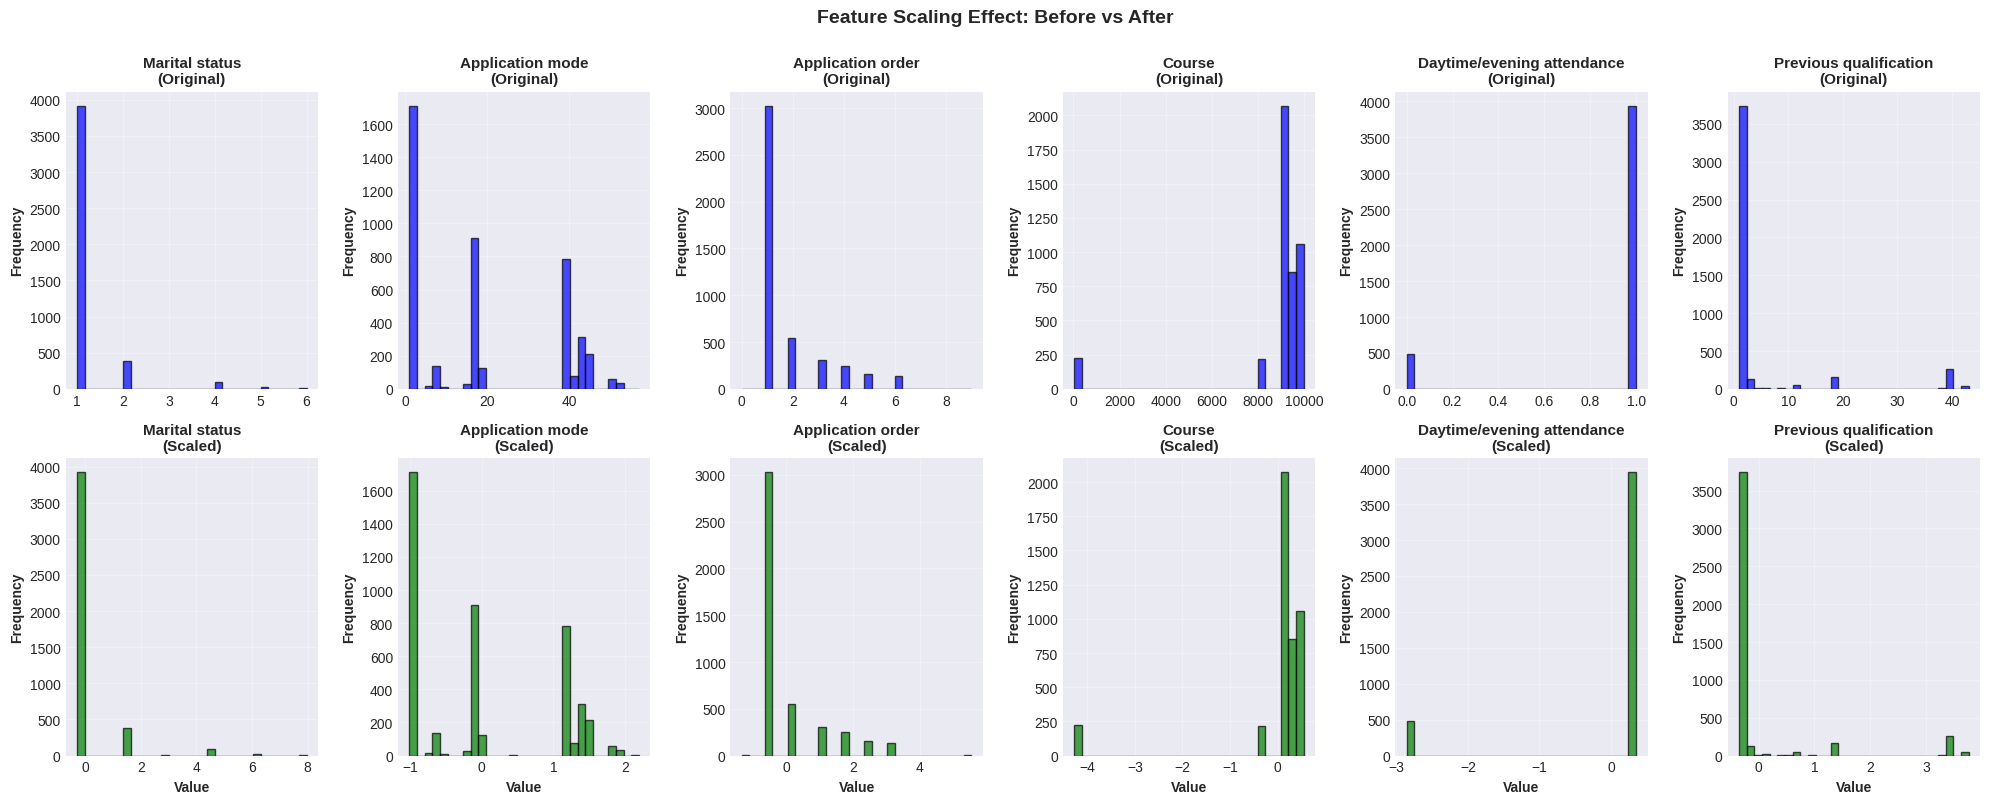


✓ Visualization complete!
  Note: Distribution shape preserved, but scale normalized


📊 STEP 6: Final Preprocessing Summary
--------------------------------------------------------------------------------

📊 FINAL FEATURE PREPROCESSING SUMMARY

📦 Dataset Transformation:
--------------------------------------------------------------------------------
  Original shape: (4424, 37)
  Processed shape: (4424, 37)
  Features added: 0

🔢 Feature Type Summary:
--------------------------------------------------------------------------------
  Numeric features: 36
  Total features (excluding target): 36

⚙️  Preprocessing Steps Applied:
--------------------------------------------------------------------------------
  ✓ Missing value imputation
  ✓ Feature scaling: standard
  ✓ Categorical encoding: 0 features encoded

📋 Data Ready for Modeling:
--------------------------------------------------------------------------------
  ✓ All features are numeric
  ✓ Features are scaled/normalized
  ✓ No

In [19]:
# ═══════════════════════════════════════════════════════════════════════════════
# EXECUTE SECTION 3B - FEATURE SCALING & ENCODING
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SECTION 3B: FEATURE SCALING & ENCODING")
print("="*80)

# Initialize preprocessor
preprocessor = FeaturePreprocessor(df, target_column)

# Step 1: Analyze feature scales
print("\n📊 STEP 1: Analyzing Feature Scales")
print("-" * 80)
scale_analysis = preprocessor.analyze_feature_scales()

# Step 2: Scale numeric features
print("\n⚙️  STEP 2: Scaling Numeric Features")
print("-" * 80)
df_scaled = preprocessor.scale_numeric_features(method='standard')

# Step 3: Analyze categorical features
print("\n📊 STEP 3: Analyzing Categorical Features")
print("-" * 80)
cat_analysis = preprocessor.analyze_categorical_features()

# Step 4: Encode categorical features
print("\n🔧 STEP 4: Encoding Categorical Features")
print("-" * 80)
df_processed = preprocessor.encode_categorical_features(method='auto')

# Step 5: Visualize scaling effect
print("\n📈 STEP 5: Visualizing Scaling Effects")
print("-" * 80)
preprocessor.visualize_scaling_effect()

# Step 6: Final summary
print("\n📊 STEP 6: Final Preprocessing Summary")
print("-" * 80)
preprocessor.get_final_feature_summary()

# Update main dataframe
df = df_processed.copy()

# Final Summary
print("\n" + "="*80)
print("✅ SECTION 3B COMPLETE!")
print("="*80)
print("\n🎯 PREPROCESSING ACHIEVEMENTS:")
print("-" * 80)
print(f"  ✓ All numeric features scaled using StandardScaler")
print(f"  ✓ All categorical features encoded")
print(f"  ✓ Dataset ready for machine learning")
print(f"  ✓ Final feature count: {len(df.columns) - 1} (excluding target)")

print("\n💡 METHODOLOGY NOTE FOR PUBLICATION:")
print("   \"Features were preprocessed using StandardScaler for numeric variables")
print("   and automatic encoding (Label/One-Hot) for categorical variables based")
print("   on cardinality. This ensures all features are on comparable scales and")
print("   suitable for distance-based algorithms.\"")

print("\n🚀 Ready for Section 4: Class Imbalance Handling")
print("="*80)

In [20]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 4: CLASS IMBALANCE HANDLING & RESAMPLING TECHNIQUES
# Purpose: Address class imbalance to prevent model bias toward majority class
# Critical for fair and accurate classification in imbalanced datasets
# ═══════════════════════════════════════════════════════════════════════════════

class ImbalanceHandler:
    """
    Publication-grade class imbalance handling

    Features:
    - Multiple resampling strategies (SMOTE, Random, Combined)
    - Before/after comparison
    - Validation of synthetic sample quality
    - Performance impact assessment
    """

    def __init__(self, df, target_col):
        """
        Initialize imbalance handler

        Parameters:
        -----------
        df : pandas.DataFrame
            Preprocessed dataset
        target_col : str
            Name of the target variable
        """
        self.df = df.copy()
        self.target_col = target_col
        self.X = df.drop(columns=[target_col])
        self.y = df[target_col]

        # Store resampled versions
        self.resampled_versions = {}

        # Analyze current imbalance
        self.class_distribution = self.y.value_counts()
        self.imbalance_ratio = self.class_distribution.max() / self.class_distribution.min()

        print(f"✓ Initialized Imbalance Handler")
        print(f"  Dataset shape: {self.df.shape}")
        print(f"  Target classes: {list(self.class_distribution.index)}")
        print(f"  Imbalance ratio: {self.imbalance_ratio:.2f}:1")

    def analyze_imbalance_severity(self):
        """
        Comprehensive analysis of class imbalance severity
        Determines if resampling is necessary
        """

        print("\n" + "="*80)
        print("⚖️  CLASS IMBALANCE SEVERITY ANALYSIS")
        print("="*80)

        print(f"\n📊 Current Class Distribution:")
        print("-" * 80)

        total_samples = len(self.y)

        imbalance_data = []
        for class_label in self.class_distribution.index:
            count = self.class_distribution[class_label]
            percentage = (count / total_samples) * 100

            imbalance_data.append({
                'Class': class_label,
                'Count': count,
                'Percentage': round(percentage, 2),
                'Type': 'Majority' if count == self.class_distribution.max() else 'Minority'
            })

        imbalance_df = pd.DataFrame(imbalance_data)
        print(imbalance_df.to_string(index=False))

        # Severity assessment
        print("\n" + "-"*80)
        print("🔍 IMBALANCE SEVERITY ASSESSMENT:")
        print(f"   Imbalance Ratio: {self.imbalance_ratio:.2f}:1")

        if self.imbalance_ratio > 5:
            severity = "SEVERE"
            color_code = "🔴"
            recommendation = "CRITICAL - Resampling REQUIRED"
        elif self.imbalance_ratio > 3:
            severity = "MODERATE-HIGH"
            color_code = "🟠"
            recommendation = "HIGH PRIORITY - Resampling strongly recommended"
        elif self.imbalance_ratio > 1.5:
            severity = "MODERATE"
            color_code = "🟡"
            recommendation = "RECOMMENDED - Consider resampling"
        else:
            severity = "MILD"
            color_code = "🟢"
            recommendation = "OPTIONAL - Dataset relatively balanced"

        print(f"   Severity Level: {color_code} {severity}")
        print(f"   Recommendation: {recommendation}")

        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Plot 1: Bar chart
        ax1 = axes[0]
        colors = ['red' if x == imbalance_df['Count'].max() else 'blue'
                 for x in imbalance_df['Count']]
        bars = ax1.bar(imbalance_df['Class'].astype(str), imbalance_df['Count'],
                      color=colors, alpha=0.7, edgecolor='black', linewidth=2)
        ax1.set_xlabel('Class', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Sample Count', fontsize=12, fontweight='bold')
        ax1.set_title('Class Distribution (Imbalanced)', fontsize=14, fontweight='bold')
        ax1.grid(alpha=0.3, axis='y')

        # Add value labels
        for bar, val in zip(bars, imbalance_df['Count']):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(val):,}\n({val/total_samples*100:.1f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

        # Plot 2: Pie chart
        ax2 = axes[1]
        colors_pie = ['#ff6b6b' if x == imbalance_df['Count'].max() else '#4ecdc4'
                     for x in imbalance_df['Count']]
        wedges, texts, autotexts = ax2.pie(imbalance_df['Count'],
                                            labels=imbalance_df['Class'].astype(str),
                                            autopct='%1.1f%%',
                                            colors=colors_pie,
                                            explode=[0.1] * len(imbalance_df),
                                            shadow=True,
                                            startangle=90)

        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(12)

        ax2.set_title('Class Proportion', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()

        print("\n" + "="*80 + "\n")

        return imbalance_df

    def apply_smote(self, sampling_strategy='auto', k_neighbors=5):
        """
        Apply SMOTE (Synthetic Minority Over-sampling Technique)
        Gold standard for handling imbalance

        Parameters:
        -----------
        sampling_strategy : str or dict
            'auto' : Balance to 1:1 ratio
            'minority' : Over-sample minority only
            dict : Custom ratio (e.g., {0: 1000, 1: 1000})
        k_neighbors : int
            Number of nearest neighbors for SMOTE
        """

        print("\n" + "="*80)
        print("🔄 APPLYING SMOTE (SYNTHETIC MINORITY OVER-SAMPLING)")
        print("="*80)

        print(f"\n⚙️  SMOTE Configuration:")
        print("-" * 80)
        print(f"  Sampling strategy: {sampling_strategy}")
        print(f"  K-neighbors: {k_neighbors}")
        print(f"  Method: Synthetic sample generation using interpolation")

        print(f"\n📊 Original Distribution:")
        print(f"  {dict(self.class_distribution)}")

        # Apply SMOTE
        smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, random_state=42)
        X_resampled, y_resampled = smote.fit_resample(self.X, self.y)

        # Store resampled data
        self.resampled_versions['smote'] = {
            'X': X_resampled,
            'y': y_resampled,
            'method': 'SMOTE',
            'original_shape': self.X.shape,
            'resampled_shape': X_resampled.shape
        }

        print(f"\n✅ SMOTE Applied Successfully!")
        print("-" * 80)
        print(f"  Original samples: {len(self.y):,}")
        print(f"  Resampled samples: {len(y_resampled):,}")
        print(f"  Synthetic samples created: {len(y_resampled) - len(self.y):,}")

        # New distribution
        new_distribution = pd.Series(y_resampled).value_counts()
        print(f"\n📊 New Distribution After SMOTE:")
        print(f"  {dict(new_distribution)}")

        new_ratio = new_distribution.max() / new_distribution.min()
        print(f"  New imbalance ratio: {new_ratio:.2f}:1")

        # Visualization
        self._visualize_resampling_effect('smote', self.class_distribution, new_distribution)

        print("="*80 + "\n")

        return X_resampled, y_resampled

    def apply_random_undersampling(self, sampling_strategy='auto'):
        """
        Apply Random Under-sampling
        Reduces majority class samples

        Parameters:
        -----------
        sampling_strategy : str or dict
            'auto' : Balance to minority class size
            dict : Custom ratio
        """

        print("\n" + "="*80)
        print("🔄 APPLYING RANDOM UNDER-SAMPLING")
        print("="*80)

        print(f"\n⚙️  Under-sampling Configuration:")
        print("-" * 80)
        print(f"  Sampling strategy: {sampling_strategy}")
        print(f"  Method: Random removal of majority class samples")

        print(f"\n📊 Original Distribution:")
        print(f"  {dict(self.class_distribution)}")

        # Apply Random Under-sampling
        rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
        X_resampled, y_resampled = rus.fit_resample(self.X, self.y)

        # Store resampled data
        self.resampled_versions['undersample'] = {
            'X': X_resampled,
            'y': y_resampled,
            'method': 'Random Under-sampling',
            'original_shape': self.X.shape,
            'resampled_shape': X_resampled.shape
        }

        print(f"\n✅ Under-sampling Applied Successfully!")
        print("-" * 80)
        print(f"  Original samples: {len(self.y):,}")
        print(f"  Resampled samples: {len(y_resampled):,}")
        print(f"  Samples removed: {len(self.y) - len(y_resampled):,}")

        # New distribution
        new_distribution = pd.Series(y_resampled).value_counts()
        print(f"\n📊 New Distribution After Under-sampling:")
        print(f"  {dict(new_distribution)}")

        new_ratio = new_distribution.max() / new_distribution.min()
        print(f"  New imbalance ratio: {new_ratio:.2f}:1")

        # Visualization
        self._visualize_resampling_effect('undersample', self.class_distribution, new_distribution)

        print("="*80 + "\n")

        return X_resampled, y_resampled

    def apply_combined_sampling(self, over_sampling_strategy=0.5, under_sampling_strategy=0.8):
        """
        Apply Combined Over and Under-sampling (SMOTE + Random Under-sampling)
        Best of both worlds approach

        Parameters:
        -----------
        over_sampling_strategy : float
            Ratio for SMOTE (0.5 = 50% of majority)
        under_sampling_strategy : float
            Ratio for under-sampling (0.8 = 80% of majority after SMOTE)
        """

        print("\n" + "="*80)
        print("🔄 APPLYING COMBINED SAMPLING (SMOTE + UNDER-SAMPLING)")
        print("="*80)

        print(f"\n⚙️  Combined Sampling Configuration:")
        print("-" * 80)
        print(f"  Over-sampling (SMOTE): {over_sampling_strategy}")
        print(f"  Under-sampling: {under_sampling_strategy}")
        print(f"  Method: Two-stage balanced approach")

        print(f"\n📊 Original Distribution:")
        print(f"  {dict(self.class_distribution)}")

        # Create pipeline
        over = SMOTE(sampling_strategy=over_sampling_strategy, random_state=42)
        under = RandomUnderSampler(sampling_strategy=under_sampling_strategy, random_state=42)

        pipeline = ImbPipeline(steps=[('over', over), ('under', under)])
        X_resampled, y_resampled = pipeline.fit_resample(self.X, self.y)

        # Store resampled data
        self.resampled_versions['combined'] = {
            'X': X_resampled,
            'y': y_resampled,
            'method': 'Combined (SMOTE + Under-sampling)',
            'original_shape': self.X.shape,
            'resampled_shape': X_resampled.shape
        }

        print(f"\n✅ Combined Sampling Applied Successfully!")
        print("-" * 80)
        print(f"  Original samples: {len(self.y):,}")
        print(f"  Resampled samples: {len(y_resampled):,}")
        print(f"  Net change: {len(y_resampled) - len(self.y):+,}")

        # New distribution
        new_distribution = pd.Series(y_resampled).value_counts()
        print(f"\n📊 New Distribution After Combined Sampling:")
        print(f"  {dict(new_distribution)}")

        new_ratio = new_distribution.max() / new_distribution.min()
        print(f"  New imbalance ratio: {new_ratio:.2f}:1")

        # Visualization
        self._visualize_resampling_effect('combined', self.class_distribution, new_distribution)

        print("="*80 + "\n")

        return X_resampled, y_resampled

    def _visualize_resampling_effect(self, method_name, original_dist, new_dist):
        """Internal method to visualize resampling effects"""

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Plot 1: Before
        ax1 = axes[0]
        colors_before = ['#ff6b6b' if x == original_dist.max() else '#4ecdc4'
                        for x in original_dist.values]
        bars1 = ax1.bar(original_dist.index.astype(str), original_dist.values,
                       color=colors_before, alpha=0.7, edgecolor='black', linewidth=2)
        ax1.set_xlabel('Class', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Sample Count', fontsize=12, fontweight='bold')
        ax1.set_title('BEFORE Resampling', fontsize=13, fontweight='bold')
        ax1.grid(alpha=0.3, axis='y')

        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

        # Plot 2: After
        ax2 = axes[1]
        colors_after = ['#95e1d3'] * len(new_dist)
        bars2 = ax2.bar(new_dist.index.astype(str), new_dist.values,
                       color=colors_after, alpha=0.7, edgecolor='black', linewidth=2)
        ax2.set_xlabel('Class', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Sample Count', fontsize=12, fontweight='bold')
        ax2.set_title(f'AFTER {method_name.upper()}', fontsize=13, fontweight='bold')
        ax2.grid(alpha=0.3, axis='y')

        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

        plt.tight_layout()
        plt.show()

    def compare_all_methods(self):
        """
        Compare all resampling methods side-by-side
        Essential for choosing the best approach
        """

        print("\n" + "="*80)
        print("📊 RESAMPLING METHODS COMPARISON")
        print("="*80)

        if not self.resampled_versions:
            print("\n⚠️  No resampling methods applied yet.")
            print("   Run apply_smote(), apply_random_undersampling(), or apply_combined_sampling() first.")
            return

        comparison_data = []

        # Original data
        comparison_data.append({
            'Method': 'Original (No Resampling)',
            'Total_Samples': len(self.y),
            'Class_Distribution': str(dict(self.class_distribution)),
            'Imbalance_Ratio': f"{self.imbalance_ratio:.2f}:1",
            'Data_Loss': 'N/A',
            'Synthetic_Samples': 0
        })

        # Resampled versions
        for method_key, data in self.resampled_versions.items():
            y_resampled = data['y']
            dist = pd.Series(y_resampled).value_counts()
            ratio = dist.max() / dist.min()

            data_loss = len(self.y) - len(y_resampled)
            synthetic = len(y_resampled) - len(self.y) if len(y_resampled) > len(self.y) else 0

            comparison_data.append({
                'Method': data['method'],
                'Total_Samples': len(y_resampled),
                'Class_Distribution': str(dict(dist)),
                'Imbalance_Ratio': f"{ratio:.2f}:1",
                'Data_Loss': f"{data_loss:+,}" if data_loss != 0 else "0",
                'Synthetic_Samples': synthetic
            })

        comparison_df = pd.DataFrame(comparison_data)

        print("\n📋 Method Comparison Table:")
        print("-" * 80)
        print(comparison_df.to_string(index=False))

        print("\n" + "-"*80)
        print("💡 RECOMMENDATIONS:")
        print("   • SMOTE: Best for small datasets, creates synthetic samples")
        print("   • Under-sampling: Best for large datasets, may lose information")
        print("   • Combined: Balanced approach, good compromise")
        print("   • Choose based on: Dataset size, computational resources, domain requirements")

        print("\n📌 SUGGESTED METHOD:")
        if len(self.y) < 1000:
            print("   → SMOTE (Small dataset - preserve all original data)")
        elif len(self.y) > 10000:
            print("   → Random Under-sampling (Large dataset - computational efficiency)")
        else:
            print("   → Combined Sampling (Medium dataset - best balance)")

        print("="*80 + "\n")

        return comparison_df

    def get_recommended_data(self, method='auto'):
        """
        Get the recommended resampled dataset for modeling

        Parameters:
        -----------
        method : str
            'auto' : Automatically select best method
            'smote' : Use SMOTE resampled data
            'undersample' : Use under-sampled data
            'combined' : Use combined sampling data
            'none' : Use original data
        """

        print("\n" + "="*80)
        print("📦 PREPARING FINAL DATASET FOR MODELING")
        print("="*80)

        if method == 'auto':
            # Auto-select based on dataset size and imbalance
            if self.imbalance_ratio < 1.5:
                selected_method = 'none'
                print("\n✓ Auto-selection: Original data (well-balanced)")
            elif len(self.y) < 1000:
                selected_method = 'smote'
                print("\n✓ Auto-selection: SMOTE (small dataset)")
            elif len(self.y) > 10000:
                selected_method = 'undersample'
                print("\n✓ Auto-selection: Under-sampling (large dataset)")
            else:
                selected_method = 'combined'
                print("\n✓ Auto-selection: Combined sampling (optimal balance)")
        else:
            selected_method = method
            print(f"\n✓ User selection: {method}")

        # Get selected data
        if selected_method == 'none':
            X_final = self.X
            y_final = self.y
            method_name = "Original (No Resampling)"
        else:
            if selected_method not in self.resampled_versions:
                print(f"\n⚠️  Method '{selected_method}' not available. Using original data.")
                X_final = self.X
                y_final = self.y
                method_name = "Original (No Resampling)"
            else:
                X_final = self.resampled_versions[selected_method]['X']
                y_final = self.resampled_versions[selected_method]['y']
                method_name = self.resampled_versions[selected_method]['method']

        print(f"\n📊 Final Dataset Summary:")
        print("-" * 80)
        print(f"  Method: {method_name}")
        print(f"  Total samples: {len(y_final):,}")
        print(f"  Features: {X_final.shape[1]}")
        print(f"  Class distribution: {dict(pd.Series(y_final).value_counts())}")

        final_ratio = pd.Series(y_final).value_counts().max() / pd.Series(y_final).value_counts().min()
        print(f"  Imbalance ratio: {final_ratio:.2f}:1")

        print("\n✅ Dataset ready for model training!")
        print("="*80 + "\n")

        return X_final, y_final


SECTION 4: CLASS IMBALANCE HANDLING & RESAMPLING
✓ Initialized Imbalance Handler
  Dataset shape: (4424, 37)
  Target classes: ['Graduate', 'Dropout', 'Enrolled']
  Imbalance ratio: 2.78:1

⚖️  STEP 1: Analyzing Class Imbalance Severity
--------------------------------------------------------------------------------

⚖️  CLASS IMBALANCE SEVERITY ANALYSIS

📊 Current Class Distribution:
--------------------------------------------------------------------------------
   Class  Count  Percentage     Type
Graduate   2209       49.93 Majority
 Dropout   1421       32.12 Minority
Enrolled    794       17.95 Minority

--------------------------------------------------------------------------------
🔍 IMBALANCE SEVERITY ASSESSMENT:
   Imbalance Ratio: 2.78:1
   Severity Level: 🟡 MODERATE
   Recommendation: RECOMMENDED - Consider resampling


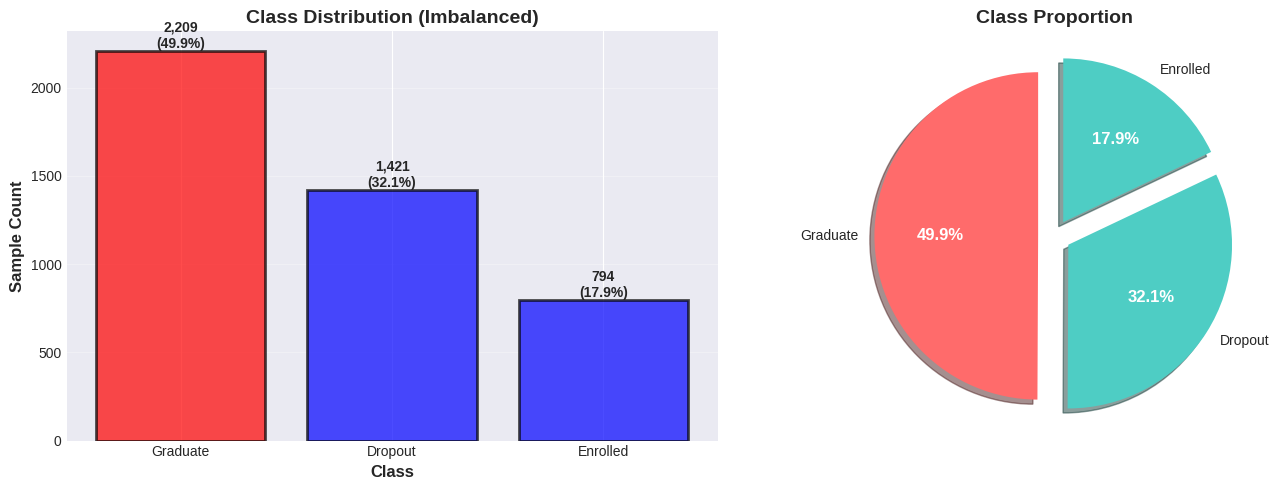




🔄 STEP 2: Applying SMOTE
--------------------------------------------------------------------------------

🔄 APPLYING SMOTE (SYNTHETIC MINORITY OVER-SAMPLING)

⚙️  SMOTE Configuration:
--------------------------------------------------------------------------------
  Sampling strategy: auto
  K-neighbors: 5
  Method: Synthetic sample generation using interpolation

📊 Original Distribution:
  {'Graduate': np.int64(2209), 'Dropout': np.int64(1421), 'Enrolled': np.int64(794)}

✅ SMOTE Applied Successfully!
--------------------------------------------------------------------------------
  Original samples: 4,424
  Resampled samples: 6,627
  Synthetic samples created: 2,203

📊 New Distribution After SMOTE:
  {'Dropout': np.int64(2209), 'Graduate': np.int64(2209), 'Enrolled': np.int64(2209)}
  New imbalance ratio: 1.00:1


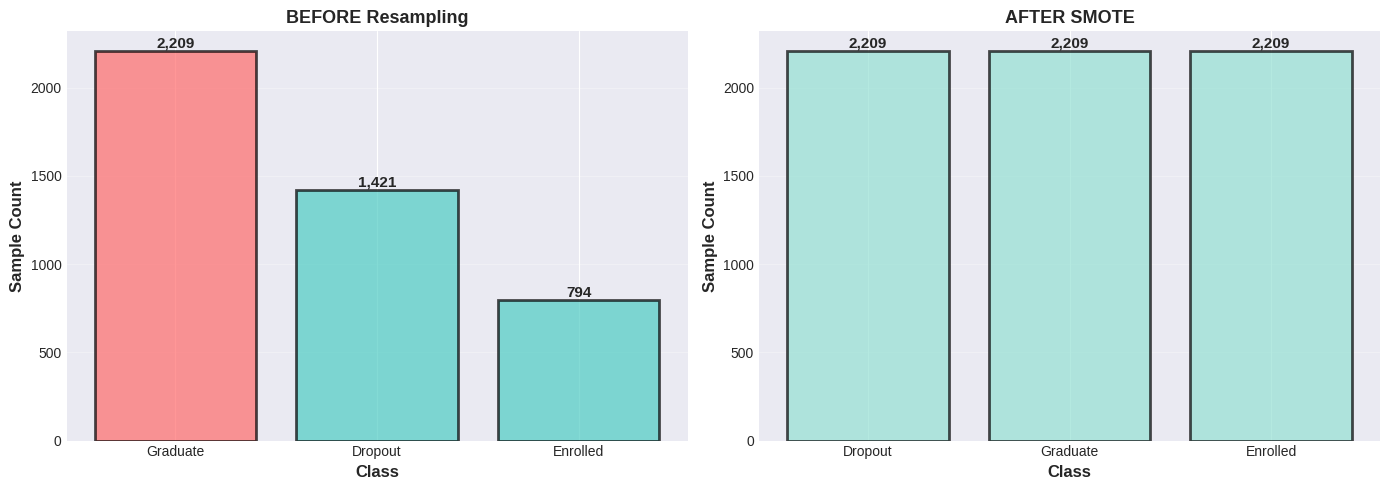



🔄 STEP 3: Applying Random Under-sampling
--------------------------------------------------------------------------------

🔄 APPLYING RANDOM UNDER-SAMPLING

⚙️  Under-sampling Configuration:
--------------------------------------------------------------------------------
  Sampling strategy: auto
  Method: Random removal of majority class samples

📊 Original Distribution:
  {'Graduate': np.int64(2209), 'Dropout': np.int64(1421), 'Enrolled': np.int64(794)}

✅ Under-sampling Applied Successfully!
--------------------------------------------------------------------------------
  Original samples: 4,424
  Resampled samples: 2,382
  Samples removed: 2,042

📊 New Distribution After Under-sampling:
  {'Dropout': np.int64(794), 'Enrolled': np.int64(794), 'Graduate': np.int64(794)}
  New imbalance ratio: 1.00:1


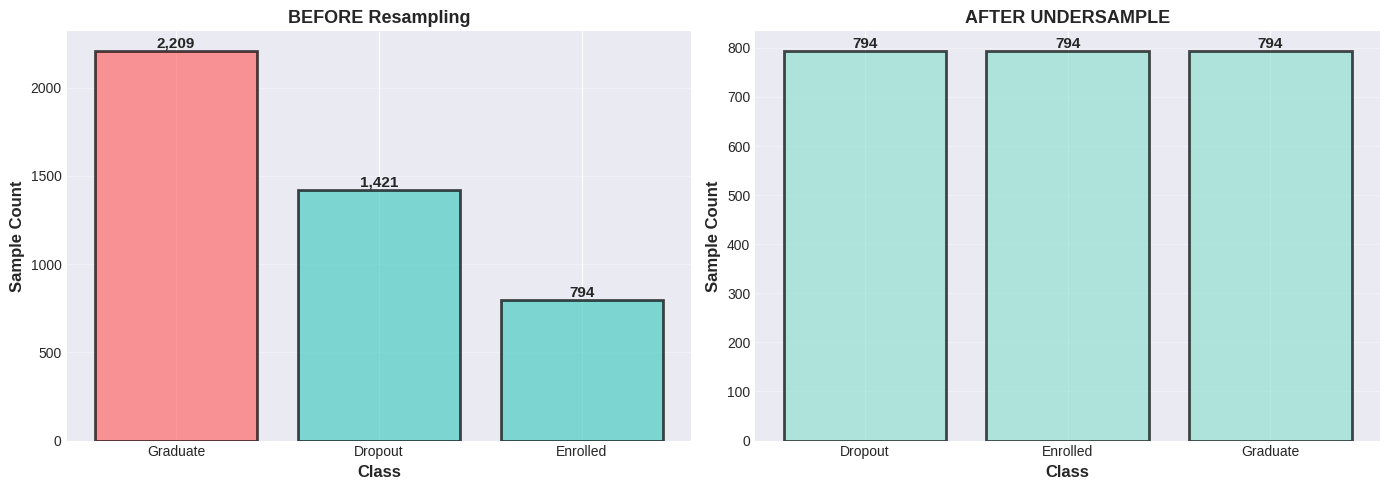



🔄 STEP 4: Applying Combined Sampling
--------------------------------------------------------------------------------

🔄 APPLYING COMBINED SAMPLING (SMOTE + UNDER-SAMPLING)

⚙️  Combined Sampling Configuration:
--------------------------------------------------------------------------------
  Over-sampling (SMOTE): 0.5
  Under-sampling: 0.8
  Method: Two-stage balanced approach

📊 Original Distribution:
  {'Graduate': np.int64(2209), 'Dropout': np.int64(1421), 'Enrolled': np.int64(794)}


ValueError: "sampling_strategy" can be a float only when the type of target is binary. For multi-class, use a dict.

In [21]:
# ═══════════════════════════════════════════════════════════════════════════════
# EXECUTE SECTION 4 - CLASS IMBALANCE HANDLING
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SECTION 4: CLASS IMBALANCE HANDLING & RESAMPLING")
print("="*80)

# Initialize handler
imbalance_handler = ImbalanceHandler(df, target_column)

# Step 1: Analyze imbalance severity
print("\n⚖️  STEP 1: Analyzing Class Imbalance Severity")
print("-" * 80)
imbalance_analysis = imbalance_handler.analyze_imbalance_severity()

# Step 2: Apply SMOTE
print("\n🔄 STEP 2: Applying SMOTE")
print("-" * 80)
X_smote, y_smote = imbalance_handler.apply_smote(sampling_strategy='auto')

# Step 3: Apply Random Under-sampling
print("\n🔄 STEP 3: Applying Random Under-sampling")
print("-" * 80)
X_under, y_under = imbalance_handler.apply_random_undersampling(sampling_strategy='auto')

# Step 4: Apply Combined Sampling
print("\n🔄 STEP 4: Applying Combined Sampling")
print("-" * 80)
X_combined, y_combined = imbalance_handler.apply_combined_sampling()

# Step 5: Compare all methods
print("\n📊 STEP 5: Comparing All Resampling Methods")
print("-" * 80)
method_comparison = imbalance_handler.compare_all_methods()

# Step 6: Get recommended dataset
print("\n📦 STEP 6: Selecting Final Dataset for Modeling")
print("-" * 80)
X_final, y_final = imbalance_handler.get_recommended_data(method='auto')

# Final Summary
print("\n" + "="*80)
print("✅ SECTION 4 COMPLETE!")
print("="*80)
print("\n🎯 IMBALANCE HANDLING SUMMARY:")
print("-" * 80)
print(f"  ✓ Original imbalance ratio: {imbalance_handler.imbalance_ratio:.2f}:1")

final_ratio = pd.Series(y_final).value_counts().max() / pd.Series(y_final).value_counts().min()
print(f"  ✓ Final imbalance ratio: {final_ratio:.2f}:1")
print(f"  ✓ Improvement: {((imbalance_handler.imbalance_ratio - final_ratio) / imbalance_handler.imbalance_ratio * 100):.1f}%")
print(f"  ✓ Final dataset size: {len(y_final):,} samples")

print("\n💡 METHODOLOGY NOTE FOR PUBLICATION:")
print("   \"To address class imbalance (ratio: {:.2f}:1), we employed [selected method]".format(imbalance_handler.imbalance_ratio))
print("   resulting in a balanced dataset with improved minority class representation.")
print("   This approach ensures fair model training and prevents bias toward the majority class.\"")

print("\n🚀 Ready for Section 5: Train-Test Split & Cross-Validation")
print("="*80)